# Titanic - Machine Learning from Disaster

## Overview

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, the goal is to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

### Problem Definition

> what sorts of people were more likely to survive?

### Data

The data has been split into two groups:

- training set (train.csv)
- test set (test.csv)

The training set was used to build the machine learning models. For the training set, it provides the outcome (also known as the “ground truth”) for each passenger. The model was based on “features” like passengers’ gender and class. 

The test set was used to see how well the model performed on unseen data. For each passenger in the test set, the model was trained to predict whether or not they survived the sinking of the Titanic.

Also includes is the gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what the submission file should look like.

For more details, checkout the [data dictionary](https://www.kaggle.com/competitions/titanic/data)

### Evaluation

> The score is the percentage of passengers the model correctly predicted. This is known as accuracy.

### Features
#### Data Analysis EDA

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.metrics import accuracy_score 
from sklearn.svm import LinearSVC 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, StratifiedKFold 
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
import optuna as opt
import xgboost as xgb
import catboost as cat
%matplotlib inline

In [2]:
# load data 
df = pd.read_csv('data/train.csv')
df.sample(frac=.2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
785,786,0,3,"Harmer, Mr. Abraham (David Lishin)",male,25.0,0,0,374887,7.2500,NaN,S
688,689,0,3,"Fischer, Mr. Eberhard Thelander",male,18.0,0,0,350036,7.7958,NaN,S
197,198,0,3,"Olsen, Mr. Karl Siegwart Andreas",male,42.0,0,1,4579,8.4042,NaN,S
225,226,0,3,"Berglund, Mr. Karl Ivar Sven",male,22.0,0,0,PP 4348,9.3500,NaN,S
110,111,0,1,"Porter, Mr. Walter Chamberlain",male,47.0,0,0,110465,52.0000,C110,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
647,648,1,1,"Simonius-Blumer, Col. Oberst Alfons",male,56.0,0,0,13213,35.5000,A26,C
410,411,0,3,"Sdycoff, Mr. Todor",male,NaN,0,0,349222,7.8958,NaN,S
287,288,0,3,"Naidenoff, Mr. Penko",male,22.0,0,0,349206,7.8958,NaN,S


In [3]:
# check that the `Passengerid` feature is unique for all samples
df['PassengerId'].value_counts().sum() , df.shape[0]

(np.int64(891), 891)

In [4]:
# quick overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Note: 
- There are 891 samples/rows and 12 columns/varibles (11 features, 1 label).
- There are some non-numeric features.
- Based on the total number of rows there are some missing values in some features like `Age`, `Cabin`...

In [5]:
# check dimension of data
df.shape 

(891, 12)

In [6]:
# check that labels have only 2 unique values
df.Survived.value_counts() 

Survived
0    549
1    342
Name: count, dtype: int64

In [7]:
# quick descriptive statistics
df.describe() 

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Note:
- The majority of passengers came with at least one person (sibling, spouse, parent, or child)
- There seem to be an outlier in the `Age` column - `0.42  `, need to visualize to comfirm. Might be an outlier, or a toddler i.e 42% of 12 (couple of months old).
- Seems some person's did not pay for the fare, min value is `0` might be crew members, need to visualize.
- Less passengers survived.
- The majority of passengers bought 3rd class tickets. 
- The majority of passegers were young adults less than 40 years of age.

### Data Visualization

In [8]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [9]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

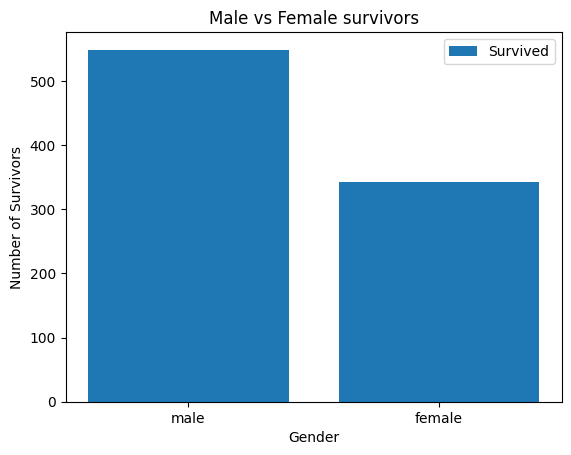

In [10]:
# check the number of survivors with respect to gender 
fig, ax = plt.subplots()
ax.bar(df.Sex.unique(), df.Survived.value_counts(), label='Survived');
ax.set(xlabel='Gender',
       ylabel='Number of Survivors',
       title="Male vs Female survivors")
ax.legend();


In [11]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


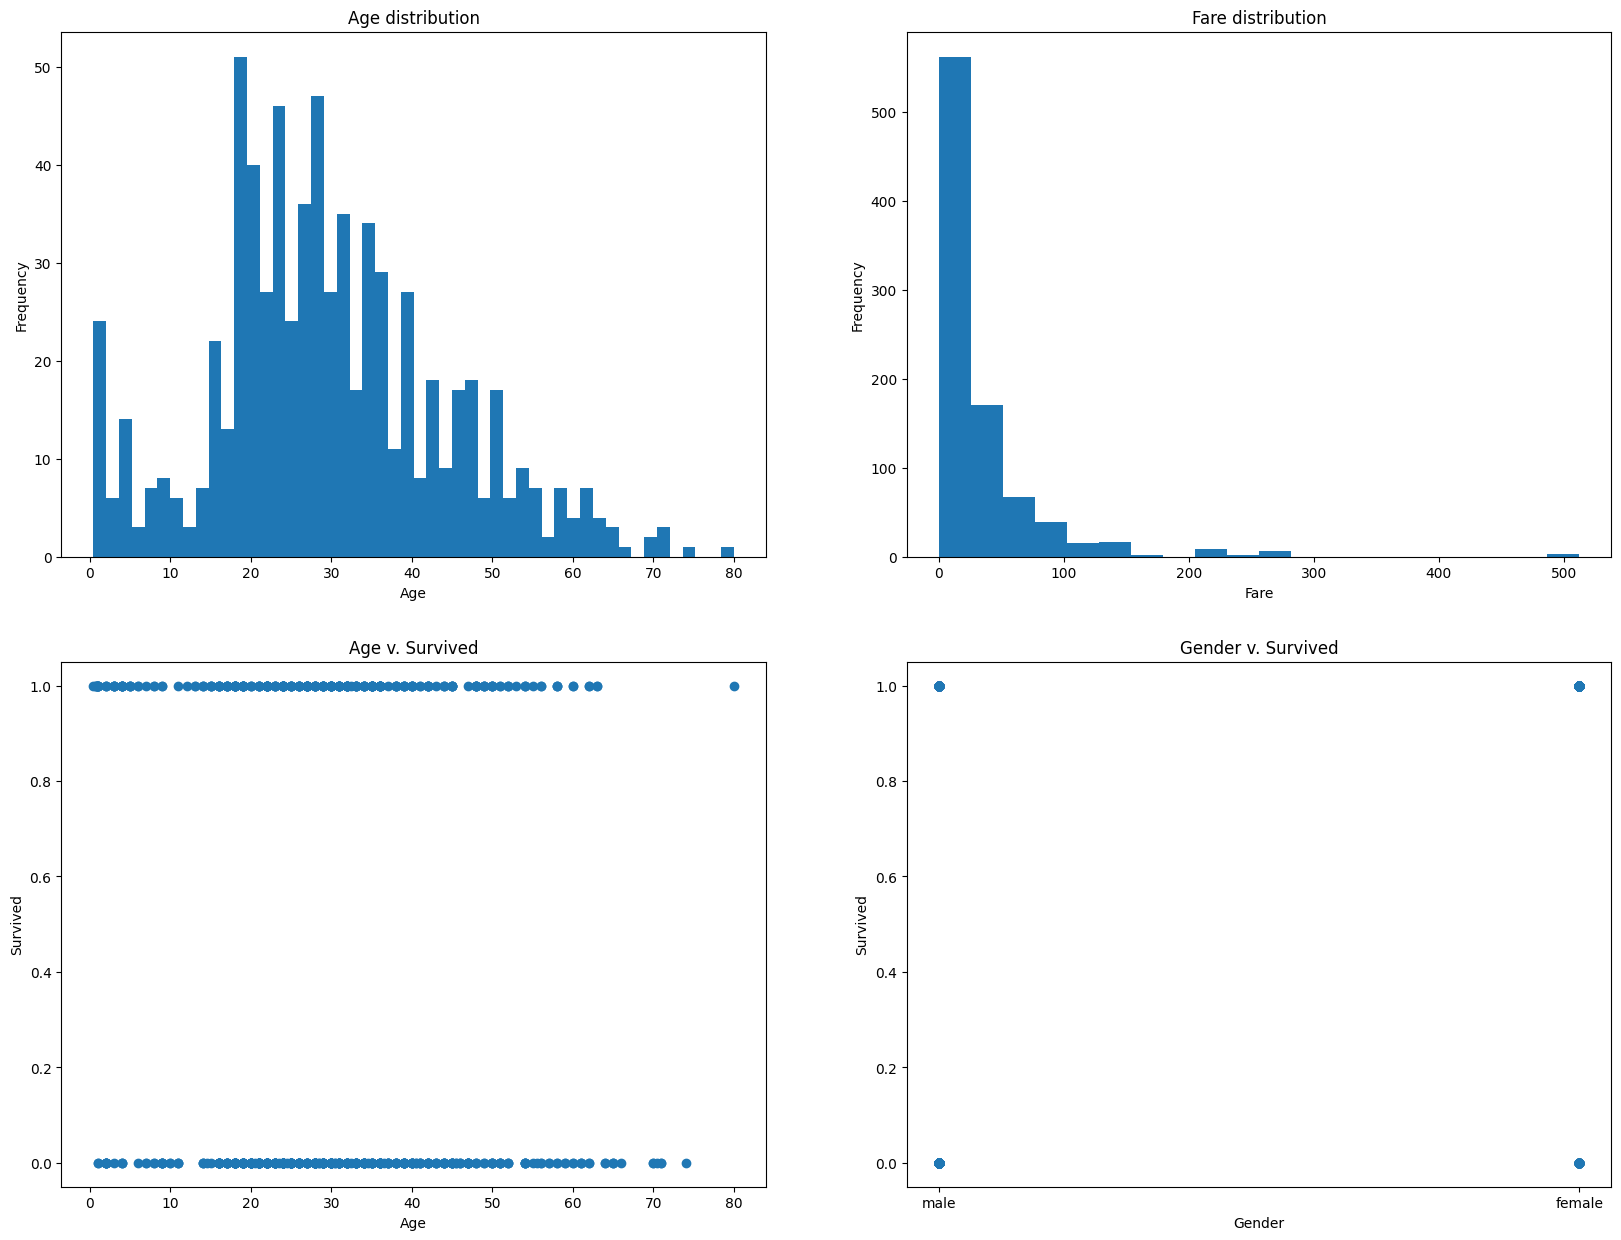

In [12]:
# age distribution, fare distribution, scatter plot between age and survival, gender and survival
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
ax1.hist(df.Age, bins=50)
ax2.hist(df.Fare, bins=20)
ax3.scatter(df.Age, df.Survived)
ax4.scatter(df.Sex, df.Survived)

ax1.set(title='Age distribution',
        xlabel='Age',
        ylabel='Frequency')

ax2.set(title='Fare distribution',
        xlabel='Fare',
        ylabel='Frequency')

ax3.set(title='Age v. Survived',
        xlabel='Age',
        ylabel='Survived')

ax4.set(title='Gender v. Survived',
        xlabel='Gender',
        ylabel='Survived');


In [13]:
pd.crosstab(df.Sex, df.Survived.value_counts())

count,342,549
Sex,,
female,1,0
male,0,1


## Modelling

In [14]:
# duplicate df
df_mod = df.copy() 
df_mod.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data Modelling EDA:  Preprocessing

In [15]:
# re-confirm if there are missing values in the dataset
df_mod.isna().sum() 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [16]:
for label,content in df_mod.items():
    if content.isna().sum():
        print(label)

Age
Cabin
Embarked


There are missing values in 3 features

#### Address missing values

In [17]:
df_mod.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [18]:
df_mod.Fare.unique().sum()

np.float64(10056.312600000001)

In [19]:
df_mod.Age.isna().sum(), len(df_mod)

(np.int64(177), 891)

Missing values will be filled accordingly:
- Age: Median and indicator column 
- Cabin: 'Missing' and indicator column
- Embarked: 'M' and indicator column 

In [20]:
# fix all missing values
for label,content in df_mod.items():
    if (label=='Age'):
         if pd.isna(content).sum():
                df_mod[label + '_is_missing'] = pd.isna(content)
                df_mod[label] = content.fillna(content.median())
    elif (label=='Cabin'):
         if pd.isna(content).sum():
              df_mod[label + '_is_missing'] = pd.isna(content)
              df_mod[label] = content.fillna('Missing')
    elif (label=='Embarked'):
         if pd.isna(content).sum():
              df_mod[label + '_is_missing'] = pd.isna(content)
              df_mod[label] = content.fillna('M') 

In [21]:
df_mod.isna().sum()

PassengerId            0
Survived               0
Pclass                 0
Name                   0
Sex                    0
Age                    0
SibSp                  0
Parch                  0
Ticket                 0
Fare                   0
Cabin                  0
Embarked               0
Age_is_missing         0
Cabin_is_missing       0
Embarked_is_missing    0
dtype: int64

In [22]:
df_mod.Age_is_missing.value_counts(), df_mod.Cabin_is_missing.value_counts(), df_mod.Embarked_is_missing.value_counts()

(Age_is_missing
 False    714
 True     177
 Name: count, dtype: int64,
 Cabin_is_missing
 True     687
 False    204
 Name: count, dtype: int64,
 Embarked_is_missing
 False    889
 True       2
 Name: count, dtype: int64)

Missing values fixed

#### Address Non-numerical data/values

In [23]:
# re-confirm if there are non-numerical data in the dataset 
for label,content in df_mod.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

Name
Sex
Ticket
Cabin
Embarked


In [24]:
len(df_mod.Name.unique())

891

In [25]:
df_mod.dtypes 

PassengerId              int64
Survived                 int64
Pclass                   int64
Name                    object
Sex                     object
Age                    float64
SibSp                    int64
Parch                    int64
Ticket                  object
Fare                   float64
Cabin                   object
Embarked                object
Age_is_missing            bool
Cabin_is_missing          bool
Embarked_is_missing       bool
dtype: object

There are 5 features [Name, Sex, Ticket, Cabin, Embarked] that are non-numeric

In [26]:
df_mod.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_is_missing,Cabin_is_missing,Embarked_is_missing
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Missing,S,False,True,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False,False,False


In [27]:
# re-confirm if there are non-numerical data in the dataset 
for label,content in df_mod.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

Name
Sex
Ticket
Cabin
Embarked


Steps to converting non-numerical values to numerical
- `Name`: Extract regular titles, store irregular titles as `other` and put under a column called 'Titles`, then drop the `Name` column - Feature Engineering.
- `Sex`and `Embarked`: convert using pd.get_dummies
- `Cabin`: Create `Deck` feature for decks to avoid high-cardinality, then drop column - Feature Engineering.
- `Ticket`: Convert using Categorical method

#### `Name` (Feature engineering)

In [28]:
df_mod.Name.sample(frac=.2).unique()

array(['Woolner, Mr. Hugh', 'Aks, Mrs. Sam (Leah Rosen)',
       'Greenberg, Mr. Samuel', 'McNamee, Mr. Neal',
       'Stewart, Mr. Albert A',
       'Allison, Mrs. Hudson J C (Bessie Waldo Daniels)',
       'Sawyer, Mr. Frederick Charles', 'White, Mr. Percival Wayland',
       'Kink-Heilmann, Miss. Luise Gretchen',
       'Gillespie, Mr. William Henry',
       'Skoog, Mrs. William (Anna Bernhardina Karlsson)',
       'Laitinen, Miss. Kristina Sofia', 'Buss, Miss. Kate',
       'Dodge, Master. Washington', 'Culumovic, Mr. Jeso',
       'Asim, Mr. Adola', 'Davies, Mr. Alfred J',
       'Honkanen, Miss. Eliina', 'Canavan, Miss. Mary',
       'Davies, Master. John Morgan Jr', 'Ali, Mr. William',
       'Sharp, Mr. Percival James R', 'McDermott, Miss. Brigdet Delia',
       'Glynn, Miss. Mary Agatha', 'Petranec, Miss. Matilda',
       'Taussig, Mrs. Emil (Tillie Mandelbaum)', 'Tobin, Mr. Roger',
       'Emanuel, Miss. Virginia Ethel', 'Moran, Mr. Daniel J',
       'Skoog, Master. Harald', 

In [29]:
# Extract regular titles form Name feature
titles = ['Mr', 'Mrs', 'Master', 'Miss', 'Dr', 'Rev']

df_mod['Titles'] = df_mod.Name.str.extract(rf'({"|".join(titles)})', expand=False).fillna('Other')

In [30]:
# drop Name column 
df_mod = df_mod.drop('Name', axis=1)

In [31]:
# confirm results
df_mod.sample(frac=.002)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_is_missing,Cabin_is_missing,Embarked_is_missing,Titles
454,455,0,3,male,28.0,0,0,A/5 2817,8.05,Missing,S,True,True,False,Mr
666,667,0,2,male,25.0,0,0,234686,13.00,Missing,S,False,True,False,Mr


In [32]:
len(df_mod.Titles.unique())

6

In [33]:
# convert Titles feature to numerical 
df_mod = pd.concat([df_mod, pd.get_dummies(df_mod.Titles, prefix='_Titles')], axis=1)

In [34]:
df_mod = df_mod.drop('Titles', axis=1)

In [35]:
df_mod.head(1)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_is_missing,Cabin_is_missing,Embarked_is_missing,_Titles_Dr,_Titles_Master,_Titles_Miss,_Titles_Mr,_Titles_Other,_Titles_Rev
0,1,0,3,male,22.0,1,0,A/5 21171,7.25,Missing,S,False,True,False,False,False,False,True,False,False


In [36]:
# re-confirm if there are non-numerical data in the dataset 
for label,content in df_mod.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

Sex
Ticket
Cabin
Embarked


#### `Sex` and `Embarked` - pd.get_dummies() 

In [37]:
df_mod = pd.concat([df_mod, pd.get_dummies(df_mod[['Sex', 'Embarked']], prefix=['Sex_', 'Embarked_'])], axis=1)

In [38]:
# drop `Sex` and `Embarked` columns
df_mod = df_mod.drop(columns=['Sex', 'Embarked'], axis=1)

In [39]:
# confirm result
df_mod.head().T

,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Age,22.0,38.0,26.0,35.0,35.0
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Ticket,A/5 21171,PC 17599,STON/O2. 3101282,113803,373450
Fare,7.25,71.2833,7.925,53.1,8.05
Cabin,Missing,C85,Missing,C123,Missing
Age_is_missing,False,False,False,False,False


In [40]:
# re-confirm if there are non-numerical data in the dataset 
for label,content in df_mod.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

Ticket
Cabin


- `Cabin`: Create `Deck` feature for decks to avoid high-cardinality, then drop column - Feature Engineering.
- `Ticket`: Convert using Categorical method

#### `Cabin` (Feature Engineering)

In [41]:
# check proportion of missing data in the Cabin column
len(df_mod[df_mod.Cabin == 'Missing'])/len(df_mod)*100

77.10437710437711

There are about 80% of missing data/samples in the `Cabin` feature. Normally, I should drop this feature as this is quite much, but for the sake of practise, I will feature engineer this.

In [42]:
# Extract first letter from column values
df_mod['Deck'] = df_mod.Cabin.str.extract(r'([A-Za-z])', expand=False)

In [43]:
# drop Cabin column
df_mod = df_mod.drop('Cabin', axis=1)

In [44]:
# Convert to numerical 
df_mod.Deck.value_counts() 

Deck
M    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64

In [45]:
# replace M with -1
df_mod['Deck'] = df_mod['Deck'].replace('M', -1)

# convert to numerical without ordering
df_mod.Deck = df_mod.Deck.astype('category').cat.codes

In [46]:
# confirm result
df_mod.Age = df_mod.Age.astype('int64')
df_mod.head(2).T 

,0,1
PassengerId,1,2
Survived,0,1
Pclass,3,1
Age,22,38
SibSp,1,1
Parch,0,0
Ticket,A/5 21171,PC 17599
Fare,7.25,71.2833
Age_is_missing,False,False
Cabin_is_missing,True,False


In [47]:
# re-confirm if there are non-numerical data in the dataset 
for label,content in df_mod.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

Ticket


- `Ticket`: Convert using Categorical method

#### `Ticket` - Categorical 


In [48]:
# convert to categorical data and order
df_mod.Ticket = df_mod['Ticket'].astype('category').cat.as_ordered()

# convert to numerical
df_mod.Ticket = df_mod['Ticket'].cat.codes

In [49]:
# confirm result
df_mod.head(1).T

,0
PassengerId,1
Survived,0
Pclass,3
Age,22
SibSp,1
Parch,0
Ticket,523
Fare,7.25
Age_is_missing,False
Cabin_is_missing,True


In [50]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PassengerId          891 non-null    int64  
 1   Survived             891 non-null    int64  
 2   Pclass               891 non-null    int64  
 3   Age                  891 non-null    int64  
 4   SibSp                891 non-null    int64  
 5   Parch                891 non-null    int64  
 6   Ticket               891 non-null    int16  
 7   Fare                 891 non-null    float64
 8   Age_is_missing       891 non-null    bool   
 9   Cabin_is_missing     891 non-null    bool   
 10  Embarked_is_missing  891 non-null    bool   
 11  _Titles_Dr           891 non-null    bool   
 12  _Titles_Master       891 non-null    bool   
 13  _Titles_Miss         891 non-null    bool   
 14  _Titles_Mr           891 non-null    bool   
 15  _Titles_Other        891 non-null    boo

In [51]:
pd.api.types.is_object_dtype(df_mod), pd.api.types.is_string_dtype(df_mod)

(False, False)

### Modelling

In [71]:
df_mod.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Age_is_missing', 'Cabin_is_missing', 'Embarked_is_missing',
       '_Titles_Dr', '_Titles_Master', '_Titles_Miss', '_Titles_Mr',
       '_Titles_Other', '_Titles_Rev', 'Sex__female', 'Sex__male',
       'Embarked__C', 'Embarked__M', 'Embarked__Q', 'Embarked__S', 'Deck'],
      dtype='object')

In [72]:
# split data into train and validation sets

X = df_mod.drop('Survived', axis=1) # training set
y = df_mod['Survived'] # validation set

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=12, stratify=y)

In [73]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape 

((712, 23), (179, 23), (712,), (179,))

In [74]:
X_valid.head()

,PassengerId,Pclass,Age,SibSp,Parch,Ticket,Fare,Age_is_missing,Cabin_is_missing,Embarked_is_missing,...,_Titles_Mr,_Titles_Other,_Titles_Rev,Sex__female,Sex__male,Embarked__C,Embarked__M,Embarked__Q,Embarked__S,Deck
691,692,3,4,0,1,393,13.4167,False,True,False,...,False,False,False,True,False,True,False,False,False,0
43,44,2,3,1,2,634,41.5792,False,True,False,...,False,False,False,True,False,True,False,False,False,0
666,667,2,25,0,0,123,13.0000,False,True,False,...,True,False,False,False,True,False,False,False,True,0
769,770,3,32,0,0,511,8.3625,False,True,False,...,True,False,False,False,True,False,False,False,True,0
419,420,3,10,0,2,307,24.1500,False,True,False,...,False,False,False,True,False,False,False,False,True,0


In [75]:
df_mod.shape 

(891, 24)

In [76]:
df_mod.Survived.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [77]:
'''
Since it's a classification problem, selected suitable models:
- RandomForestClassifier()
- XGBoost() - refine/improve metric score 
- Catboost()

Hyper-parameter Tunning
- RandomSearchCV - baseline
- GridSearchCV - refine tuning
- Optuna ()
''' 

"\nSince it's a classification problem, selected suitable models:\n- RandomForestClassifier()\n- XGBoost() - refine/improve metric score \n- Catboost()\n\nHyper-parameter Tunning\n- RandomSearchCV - baseline\n- GridSearchCV - refine tuning\n- Optuna ()\n"

In [78]:
models = {
    'RF' : RandomForestClassifier(random_state=12,
                                  n_estimators=100,
                                  max_depth=10,
                                  min_samples_split=5,
                                  min_samples_leaf=2,
                                  max_features='sqrt',
                                  n_jobs=-1),
    'XGB' : xgb.XGBClassifier(eval_metric='logloss', 
                              random_state=12,
                              n_estimators=100,
                              max_depth=6,
                              learning_rate=0.1,
                              subsample=0.8,
                              colsample_bytree=.8,
                              reg_alpha=.1,
                              reg_lambda=1),
    'CatBoost' : cat.CatBoostClassifier(verbose=0, 
                                        iterations=200, 
                                        random_state=12,
                                        depth=6,
                                        learning_rate=.1,
                                        l2_leaf_reg=3.0,
                                        random_strength=1.0,
                                        thread_count=-1
                                        ),
    'LinearSVC': LinearSVC(random_state=12,
                           C=1,
                           penalty='l2',
                           loss='squared_hinge',
                           max_iter=2000)
}

results = {}
for name, model in models.items():
    # preprocess if needed (scale for SVC)
    if name in ['LinearSVC']:
        scaler = StandardScaler() 
        X_train_mod = scaler.fit_transform(X_train)
        X_valid_mod = scaler.transform(X_valid)
    else: 
        X_train_mod, X_valid_mod = X_train, X_valid 
    
    model.fit(X_train_mod, y_train)
    preds = model.predict(X_valid_mod)
    results[name] = accuracy_score(y_valid, preds)
    print(f'{name}: {results[name]:.4f}')


RF: 0.8212
XGB: 0.8045
CatBoost: 0.8101
LinearSVC: 0.8101


From the results above it is clear the the top 2 most promising models are RF and CatBoost, let's however quickly tune LinearSVC to see if it holds any promise before eliminating it.

In [79]:
SVC_baseline = LinearSVC()

param_dist = {'C':np.arange(.1,5),
              'penalty':['l1', 'l2'],
              'loss':['squared_hinge'],
              'dual':[False],
              'max_iter':np.arange(100,2000,100)}

cv_svc = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
rs_svc = RandomizedSearchCV(SVC_baseline,
                            param_distributions=param_dist,
                            cv=cv_svc,
                            n_iter=10,
                            n_jobs=-1,
                            scoring='accuracy',
                            verbose=True,
                            random_state=12)

scaler = StandardScaler()
X_train_svc = scaler.fit_transform(X_train)
X_valid_svc = scaler.transform(X_valid)

rs_svc.fit(X_train_svc, y_train)
y_preds_svc = rs_svc.predict(X_valid_svc)
score_svc = accuracy_score(y_valid, y_preds_svc)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [80]:
score_svc

0.8100558659217877

In [81]:
rs_svc.best_params_

{'penalty': 'l2',
 'max_iter': np.int64(600),
 'loss': 'squared_hinge',
 'dual': False,
 'C': np.float64(0.1)}

Tune with Optuna

In [82]:
def objective(trial):
    params={'penalty':trial.suggest_categorical('penalty',['l1', 'l2']),
            'max_iter':trial.suggest_int('max_iter', 100,10000),
            'loss':trial.suggest_categorical('loss', ['squared_hinge']),
            'dual':trial.suggest_categorical('dual', [False]),
            'C':trial.suggest_float('C',.1, 30)
           }
    
    ideal_svc = LinearSVC(**params, random_state=12)

    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
    score = cross_val_score(ideal_svc,
                            X_train_svc, 
                            y_train,
                            cv=cv,
                            scoring='accuracy').mean()
    
    return score 
    
# create study
study = opt.create_study(direction='maximize')

# optimize study
study.optimize(objective, n_trials=30)

best_score_svc = study.best_value 
best_param_svc = study.best_params 

print(f'Best_score = {best_score_svc} \n Best_params = {best_param_svc}')

opt.visualization.plot_optimization_history(study).show()

[I 2025-10-01 13:16:34,457] A new study created in memory with name: no-name-de90645d-611c-4a4f-b490-7e00d6cd45e5
[I 2025-10-01 13:16:34,671] Trial 0 finished with value: 0.824386880724909 and parameters: {'penalty': 'l1', 'max_iter': 2665, 'loss': 'squared_hinge', 'dual': False, 'C': 1.734960192155859}. Best is trial 0 with value: 0.824386880724909.
[I 2025-10-01 13:16:34,717] Trial 1 finished with value: 0.824386880724909 and parameters: {'penalty': 'l2', 'max_iter': 917, 'loss': 'squared_hinge', 'dual': False, 'C': 4.151625694812467}. Best is trial 0 with value: 0.824386880724909.
c:\ProgramData\Miniconda3\envs\ML\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\ProgramData\Miniconda3\envs\ML\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\ProgramData\Miniconda3\envs\ML\Lib\site-packages\sklearn\svm\_base.py:1249

Best_score = 0.8271840835221116 
 Best_params = {'penalty': 'l1', 'max_iter': 4141, 'loss': 'squared_hinge', 'dual': False, 'C': 0.12865107867186887}


Having tried to tune `LinearSVC` with RandomizedSearchCV and Optuna with the best score being `82`% it's best to drop it and move to morre promising models

### Hyper-parameter Tuning to improve score
1. With RandomizedSearchCV

In [ ]:
# Tune CatBoost and RandomizedForestClassifier with Randomized CV

clf_rs = RandomForestClassifier(random_state=12)
cat_rs = cat.CatBoostClassifier(random_state=12)

models = {'clf': clf_rs,
          'cat': cat_rs}

clf_rs_param = {
    'n_estimators':list(range(100,300,50)),
    'max_depth':list(range(3,10)),
    'min_samples_leaf': list(range(5,20)),
    'min_samples_split': list(range(5,20)),
    'criterion':['gini', 'entropy', 'log_loss'],
    'max_features':['sqrt', 'log2', None],
    'max_leaf_nodes':list(range(20,100)),
    'min_weight_fraction_leaf': np.random.uniform(.0, .05, size=60).tolist()
}

cat_rs_param = {
    'iterations':np.arange(100,500,50).tolist(),
    'learning_rate':np.random.uniform(.05,.1, size=20).tolist(),
    'depth':np.arange(4,10).tolist(),
    'l2_leaf_reg':np.arange(1,10).tolist(),
    'subsample': np.random.uniform(.5, 1, size=20).tolist()
}

# RandomizedSearchCV function
def r_search(model, params):

    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

    r_model = RandomizedSearchCV(
        model,
        param_distributions=params,
        cv = cv,
        n_iter=20,
        scoring='accuracy',
        verbose=1,
        random_state=12,
        n_jobs=-1
    )

    r_model.fit(X_train, y_train)
    y_preds = r_model.predict(X_valid)
    score = accuracy_score(y_valid, y_preds)
    return score, f'model best parameters = {r_model.best_params_}'

In [205]:
r_search(cat_rs, cat_rs_param)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
0:	learn: 0.6436897	total: 3.29ms	remaining: 655ms
1:	learn: 0.6033176	total: 5.98ms	remaining: 592ms
2:	learn: 0.5709526	total: 8.41ms	remaining: 552ms
3:	learn: 0.5511808	total: 10.4ms	remaining: 510ms
4:	learn: 0.5243721	total: 12.4ms	remaining: 482ms
5:	learn: 0.5071791	total: 16.5ms	remaining: 533ms
6:	learn: 0.4933366	total: 18.4ms	remaining: 509ms
7:	learn: 0.4803444	total: 20.5ms	remaining: 493ms
8:	learn: 0.4676385	total: 22.5ms	remaining: 478ms
9:	learn: 0.4577413	total: 24.5ms	remaining: 465ms
10:	learn: 0.4455444	total: 26.4ms	remaining: 454ms
11:	learn: 0.4377662	total: 30.1ms	remaining: 472ms
12:	learn: 0.4311009	total: 32.2ms	remaining: 463ms
13:	learn: 0.4250367	total: 34.2ms	remaining: 454ms
14:	learn: 0.4180347	total: 36.6ms	remaining: 451ms
15:	learn: 0.4140554	total: 38.5ms	remaining: 443ms
16:	learn: 0.4084078	total: 40.6ms	remaining: 437ms
17:	learn: 0.4030466	total: 42.5ms	remaining: 430ms
18:	learn: 0

(0.8268156424581006,
 "model best parameters = {'subsample': 0.6485771921664951, 'learning_rate': 0.08266168342627189, 'l2_leaf_reg': 4, 'iterations': 200, 'depth': 4}")

In [209]:
rs_cat_best_params = {'subsample': 0.6485771921664951, 'learning_rate': 0.08266168342627189, 'l2_leaf_reg': 4, 'iterations': 200, 'depth': 4}
rs_cat_best_params 

{'subsample': 0.6485771921664951,
 'learning_rate': 0.08266168342627189,
 'l2_leaf_reg': 4,
 'iterations': 200,
 'depth': 4}

In [ ]:
r_search(clf_rs, clf_rs_param)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


(0.8268156424581006,
 "model best parameters = {'n_estimators': 150, 'min_weight_fraction_leaf': 0.012389209638971067, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_leaf_nodes': 39, 'max_features': 'log2', 'max_depth': 7, 'criterion': 'gini'}")

In [208]:
rs_clf_best_params = {'n_estimators': 150, 'min_weight_fraction_leaf': 0.012389209638971067, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_leaf_nodes': 39, 'max_features': 'log2', 'max_depth': 7, 'criterion': 'gini'}
rs_clf_best_params

{'n_estimators': 150,
 'min_weight_fraction_leaf': 0.012389209638971067,
 'min_samples_split': 11,
 'min_samples_leaf': 5,
 'max_leaf_nodes': 39,
 'max_features': 'log2',
 'max_depth': 7,
 'criterion': 'gini'}

Having ran searches using RandomSearchCV to get baseline parameters, GridSearchCV is used to narrow the tunable parameters for the best parameters.

Score with RandomSearch parameters for each model:
- CatBoost (score=0.8268156424581006):
> - 'subsample': 0.6485771921664951,
> - 'learning_rate': 0.08266168342627189,
> - 'l2_leaf_reg': 4,
> - 'iterations': 200,
> - 'depth': 4

- RandomForest (score=0.8268156424581006):
> - 'n_estimators': 150,
> - 'min_weight_fraction_leaf': 0.012389209638971067,
> - 'min_samples_split': 11,
> - 'min_samples_leaf': 5,
> - 'max_leaf_nodes': 39,
> - 'max_features': 'log2',
> - 'max_depth': 7,
> - 'criterion': 'gini'

In [234]:
cat_rs_score = 0.8268156424581006
clf_rs_score = 0.8268156424581006

2. GridSearchCV Tuning

In [232]:
# grid parameters for each model using the best parameters for each derived from previous search

clf_gs = RandomForestClassifier(random_state=12)
cat_gs = cat.CatBoostClassifier(random_state=12)

# grid search parameters
clf_gs_param = {
    'n_estimators':[100,150,200],
    'max_depth': [6,7,8],
    'min_samples_leaf': [4,5,6],
    'min_samples_split': [10,11,12],
    'criterion': ['gini'],
    'max_features': ['log2'],
    'max_leaf_nodes': [37,39,40],
    'min_weight_fraction_leaf': [0.012]
}

# catboost parameters
cat_gs_param = {
    'iterations': [200],
    'learning_rate': [.08],
    'depth': [3,4,5],
    'l2_leaf_reg': [5,6],
    'subsample': [.65],
}

def g_search(model, param):

    # create stratified CV
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

    # create model for g_search
    gs_model = GridSearchCV(model,
                            param_grid=param,
                            cv=cv,
                            n_jobs=-1,
                            verbose=1,
                            scoring='accuracy'
                            )
    
    gs_model.fit(X_train, y_train)
    y_preds = gs_model.predict(X_valid)
    g_score = accuracy_score(y_valid, y_preds)
    g_best_params = gs_model.best_params_

    return g_score, f'Best parameters = {g_best_params}'

In [ ]:
# GridSearch for catboost
g_search(cat_gs, cat_gs_param)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0:	learn: 0.6459838	total: 7.8ms	remaining: 1.55s
1:	learn: 0.6068122	total: 18.7ms	remaining: 1.85s
2:	learn: 0.5754001	total: 29.2ms	remaining: 1.92s
3:	learn: 0.5550574	total: 36.9ms	remaining: 1.81s
4:	learn: 0.5284548	total: 48.9ms	remaining: 1.91s
5:	learn: 0.5112620	total: 60.8ms	remaining: 1.97s
6:	learn: 0.4974489	total: 69.1ms	remaining: 1.9s
7:	learn: 0.4845261	total: 80.8ms	remaining: 1.94s
8:	learn: 0.4719147	total: 92.3ms	remaining: 1.96s
9:	learn: 0.4619020	total: 102ms	remaining: 1.94s
10:	learn: 0.4519723	total: 115ms	remaining: 1.98s
11:	learn: 0.4446826	total: 128ms	remaining: 2s
12:	learn: 0.4378668	total: 136ms	remaining: 1.95s
13:	learn: 0.4334273	total: 148ms	remaining: 1.96s
14:	learn: 0.4258257	total: 159ms	remaining: 1.96s
15:	learn: 0.4216716	total: 172ms	remaining: 1.98s
16:	learn: 0.4158774	total: 181ms	remaining: 1.95s
17:	learn: 0.4102763	total: 194ms	remaining: 1.96s
18:	learn: 0.4063284	total: 

(0.8268156424581006,
 "Best parameters = {'depth': 4, 'iterations': 200, 'l2_leaf_reg': 6, 'learning_rate': 0.08, 'subsample': 0.65}")

In [ ]:
cat_gs_score = 0.8268156424581006
cat_gs_best_params = {'depth': 4, 'iterations': 200, 'l2_leaf_reg': 6, 'learning_rate': 0.08, 'subsample': 0.65}

In [ ]:
# GridSearch for RF 
g_search(clf_gs, clf_gs_param)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


(0.8212290502793296,
 "Best parameters = {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'max_leaf_nodes': 37, 'min_samples_leaf': 4, 'min_samples_split': 11, 'min_weight_fraction_leaf': 0.012, 'n_estimators': 100}")

In [236]:
clf_gs_score = 0.8212290502793296
clf_gs_best_params = {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'max_leaf_nodes': 37, 'min_samples_leaf': 4, 'min_samples_split': 11, 'min_weight_fraction_leaf': 0.012, 'n_estimators': 100} 

3. Optuna Parameter Tuning

In [237]:
clf_gs_best_params 

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'max_leaf_nodes': 37,
 'min_samples_leaf': 4,
 'min_samples_split': 11,
 'min_weight_fraction_leaf': 0.012,
 'n_estimators': 100}

In [245]:
# Optuna tuning for RandomizedSearch
def objectives(trial):
    r_params = {
        'criterion':trial.suggest_categorical('criterion',['gini']),
        'max_depth':trial.suggest_int('max_depth', 8,10),
        'max_features':trial.suggest_categorical('max_features', ['log2']),
        'max_leaf_nodes':trial.suggest_int('max_leaf_nodes',37,38), # 37 default
        'min_samples_leaf':trial.suggest_int('min_samples_leaf',4,5), # 4 default
        'min_samples_split':trial.suggest_int('min_samples_split',11,12)# 11 default)
    }

    # instantiate model 
    clf_opt = RandomForestClassifier(**r_params, random_state=12, min_weight_fraction_leaf=0.012) 

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

    # score 
    score = cross_val_score(clf_opt,
                            X_train,
                            y_train,
                            cv=cv,
                            scoring='accuracy'
                            ).mean()
    
    return score

# create study
study = opt.create_study(direction='maximize')

# optimize study
study.optimize(objectives, n_trials=40)

# return metrics 
clf_opt_score = study.best_value
clf_opt_params = study.best_params

print(f'Accuracy for RF = {clf_opt_score}, \n Best parameters = {clf_opt_params}')

opt.visualization.plot_optimization_history(study).show()


[I 2025-10-02 00:27:49,666] A new study created in memory with name: no-name-cc06918c-8df2-44cd-b8d4-10422e8f3114
[I 2025-10-02 00:27:57,512] Trial 0 finished with value: 0.8286516300600807 and parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'max_leaf_nodes': 38, 'min_samples_leaf': 4, 'min_samples_split': 12}. Best is trial 0 with value: 0.8286516300600807.
[I 2025-10-02 00:28:04,907] Trial 1 finished with value: 0.825854427262878 and parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'max_leaf_nodes': 37, 'min_samples_leaf': 4, 'min_samples_split': 12}. Best is trial 0 with value: 0.8286516300600807.
[I 2025-10-02 00:28:13,243] Trial 2 finished with value: 0.8230473751600511 and parameters: {'criterion': 'gini', 'max_depth': 9, 'max_features': 'log2', 'max_leaf_nodes': 37, 'min_samples_leaf': 5, 'min_samples_split': 12}. Best is trial 0 with value: 0.8286516300600807.
[I 2025-10-02 00:28:20,037] Trial 3 finished with value: 0.82163892

Accuracy for RF = 0.8314586821629074, 
 Best parameters = {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'max_leaf_nodes': 38, 'min_samples_leaf': 4, 'min_samples_split': 11}


From the plots, it can be seen that after 20 trials, the objective value doesn't seem to increase further, so no need to increase trials.

In [246]:
cat_gs_best_params

{'depth': 4,
 'iterations': 200,
 'l2_leaf_reg': 6,
 'learning_rate': 0.08,
 'subsample': 0.65}

In [252]:
# Optuna tuning for CatBoost
def objectives(trial):
    cat_params = {
        'depth':trial.suggest_int('depth',4,5),
        'iterations':trial.suggest_int('iterations',200,300),
        'l2_leaf_reg':trial.suggest_int('l2_leaf_reg',6,7),
        'learning_rate':trial.suggest_float('learning_rate',.08,.09, log=True)
    }

    # instantiate model 
    cat_opt = cat.CatBoostClassifier(**cat_params, random_state=12) 

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

    # score 
    score = cross_val_score(cat_opt,
                            X_train,
                            y_train,
                            cv=cv,
                            scoring='accuracy',
                            error_score='raise'
                            ).mean()
    
    return score

# create study
study = opt.create_study(direction='maximize')

# optimize study
study.optimize(objectives, n_trials=40)

# return metrics 
cat_opt_score = study.best_value
cat_opt_params = study.best_params

print(f'Accuracy for RF = {cat_opt_score}, \n Best parameters = {cat_opt_params}')

opt.visualization.plot_optimization_history(study).show()


[I 2025-10-02 00:57:41,802] A new study created in memory with name: no-name-b691977f-810a-47d7-a9e5-cf2952da69e9


0:	learn: 0.6455184	total: 43.3ms	remaining: 11.1s
1:	learn: 0.6059051	total: 56.5ms	remaining: 7.17s
2:	learn: 0.5764482	total: 73.2ms	remaining: 6.17s
3:	learn: 0.5576843	total: 91.9ms	remaining: 5.79s
4:	learn: 0.5311732	total: 105ms	remaining: 5.29s
5:	learn: 0.5165663	total: 121ms	remaining: 5.04s
6:	learn: 0.5018569	total: 137ms	remaining: 4.86s
7:	learn: 0.4881841	total: 155ms	remaining: 4.79s
8:	learn: 0.4744877	total: 171ms	remaining: 4.7s
9:	learn: 0.4641370	total: 190ms	remaining: 4.67s
10:	learn: 0.4542240	total: 216ms	remaining: 4.8s
11:	learn: 0.4481196	total: 224ms	remaining: 4.55s
12:	learn: 0.4407532	total: 236ms	remaining: 4.41s
13:	learn: 0.4352572	total: 256ms	remaining: 4.42s
14:	learn: 0.4275679	total: 278ms	remaining: 4.47s
15:	learn: 0.4209920	total: 304ms	remaining: 4.55s
16:	learn: 0.4153848	total: 329ms	remaining: 4.63s
17:	learn: 0.4108200	total: 346ms	remaining: 4.58s
18:	learn: 0.4071888	total: 367ms	remaining: 4.58s
19:	learn: 0.4032976	total: 383ms	remai

[I 2025-10-02 00:57:59,964] Trial 0 finished with value: 0.8371023342854329 and parameters: {'depth': 4, 'iterations': 256, 'l2_leaf_reg': 7, 'learning_rate': 0.08031808668968446}. Best is trial 0 with value: 0.8371023342854329.


0:	learn: 0.6413560	total: 13ms	remaining: 3.18s
1:	learn: 0.5990888	total: 24.1ms	remaining: 2.93s
2:	learn: 0.5681640	total: 33.6ms	remaining: 2.72s
3:	learn: 0.5479505	total: 43.8ms	remaining: 2.65s
4:	learn: 0.5208781	total: 55.5ms	remaining: 2.68s
5:	learn: 0.5062867	total: 66.6ms	remaining: 2.66s
6:	learn: 0.4916719	total: 74.4ms	remaining: 2.54s
7:	learn: 0.4780013	total: 86ms	remaining: 2.56s
8:	learn: 0.4635267	total: 93.8ms	remaining: 2.47s
9:	learn: 0.4536831	total: 102ms	remaining: 2.4s
10:	learn: 0.4436769	total: 114ms	remaining: 2.43s
11:	learn: 0.4381215	total: 122ms	remaining: 2.37s
12:	learn: 0.4334322	total: 134ms	remaining: 2.41s
13:	learn: 0.4278999	total: 149ms	remaining: 2.46s
14:	learn: 0.4201603	total: 161ms	remaining: 2.48s
15:	learn: 0.4135012	total: 169ms	remaining: 2.43s
16:	learn: 0.4078002	total: 180ms	remaining: 2.43s
17:	learn: 0.4051960	total: 192ms	remaining: 2.43s
18:	learn: 0.3999861	total: 199ms	remaining: 2.38s
19:	learn: 0.3960813	total: 212ms	rem

[I 2025-10-02 00:58:18,428] Trial 1 finished with value: 0.8483305426967398 and parameters: {'depth': 4, 'iterations': 246, 'l2_leaf_reg': 6, 'learning_rate': 0.08730643906598869}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6393780	total: 30.5ms	remaining: 7.01s
1:	learn: 0.5992429	total: 50.8ms	remaining: 5.82s
2:	learn: 0.5637961	total: 64.6ms	remaining: 4.91s
3:	learn: 0.5389143	total: 73.2ms	remaining: 4.15s
4:	learn: 0.5175615	total: 86ms	remaining: 3.88s
5:	learn: 0.4928349	total: 114ms	remaining: 4.27s
6:	learn: 0.4763511	total: 122ms	remaining: 3.89s
7:	learn: 0.4643917	total: 134ms	remaining: 3.74s
8:	learn: 0.4509894	total: 153ms	remaining: 3.78s
9:	learn: 0.4425493	total: 177ms	remaining: 3.92s
10:	learn: 0.4316216	total: 190ms	remaining: 3.81s
11:	learn: 0.4217672	total: 199ms	remaining: 3.64s
12:	learn: 0.4131542	total: 212ms	remaining: 3.55s
13:	learn: 0.4056904	total: 227ms	remaining: 3.52s
14:	learn: 0.3982115	total: 242ms	remaining: 3.48s
15:	learn: 0.3951712	total: 256ms	remaining: 3.44s
16:	learn: 0.3908789	total: 270ms	remaining: 3.4s
17:	learn: 0.3880806	total: 291ms	remaining: 3.44s
18:	learn: 0.3833591	total: 320ms	remaining: 3.57s
19:	learn: 0.3799283	total: 333ms	remai

[I 2025-10-02 00:58:36,704] Trial 2 finished with value: 0.8300502314586822 and parameters: {'depth': 5, 'iterations': 231, 'l2_leaf_reg': 7, 'learning_rate': 0.08659990936552041}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6413727	total: 17.5ms	remaining: 3.65s
1:	learn: 0.6024286	total: 34.6ms	remaining: 3.58s
2:	learn: 0.5677926	total: 105ms	remaining: 7.18s
3:	learn: 0.5432372	total: 122ms	remaining: 6.23s
4:	learn: 0.5249532	total: 136ms	remaining: 5.57s
5:	learn: 0.5035631	total: 250ms	remaining: 8.46s
6:	learn: 0.4865176	total: 266ms	remaining: 7.67s
7:	learn: 0.4742312	total: 339ms	remaining: 8.52s
8:	learn: 0.4598486	total: 365ms	remaining: 8.12s
9:	learn: 0.4487248	total: 528ms	remaining: 10.5s
10:	learn: 0.4375884	total: 543ms	remaining: 9.77s
11:	learn: 0.4277492	total: 557ms	remaining: 9.14s
12:	learn: 0.4205824	total: 676ms	remaining: 10.2s
13:	learn: 0.4124900	total: 697ms	remaining: 9.7s
14:	learn: 0.4050502	total: 788ms	remaining: 10.2s
15:	learn: 0.4007669	total: 805ms	remaining: 9.71s
16:	learn: 0.3962056	total: 822ms	remaining: 9.28s
17:	learn: 0.3932288	total: 918ms	remaining: 9.74s
18:	learn: 0.3882624	total: 934ms	remaining: 9.34s
19:	learn: 0.3844608	total: 1s	remaining

[I 2025-10-02 00:58:57,099] Trial 3 finished with value: 0.8314882300797795 and parameters: {'depth': 5, 'iterations': 209, 'l2_leaf_reg': 7, 'learning_rate': 0.08316735349106782}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6432695	total: 18.9ms	remaining: 5.56s
1:	learn: 0.6022010	total: 34.8ms	remaining: 5.09s
2:	learn: 0.5719499	total: 48.6ms	remaining: 4.73s
3:	learn: 0.5528670	total: 59.5ms	remaining: 4.33s
4:	learn: 0.5260306	total: 71.3ms	remaining: 4.13s
5:	learn: 0.5114086	total: 90.2ms	remaining: 4.35s
6:	learn: 0.4967927	total: 98.6ms	remaining: 4.05s
7:	learn: 0.4832260	total: 111ms	remaining: 4s
8:	learn: 0.4687153	total: 123ms	remaining: 3.92s
9:	learn: 0.4587288	total: 136ms	remaining: 3.88s
10:	learn: 0.4489465	total: 145ms	remaining: 3.73s
11:	learn: 0.4431862	total: 159ms	remaining: 3.75s
12:	learn: 0.4386184	total: 175ms	remaining: 3.8s
13:	learn: 0.4331091	total: 189ms	remaining: 3.79s
14:	learn: 0.4252355	total: 201ms	remaining: 3.76s
15:	learn: 0.4184893	total: 216ms	remaining: 3.77s
16:	learn: 0.4126720	total: 230ms	remaining: 3.76s
17:	learn: 0.4080145	total: 244ms	remaining: 3.76s
18:	learn: 0.4043621	total: 256ms	remaining: 3.72s
19:	learn: 0.4016282	total: 272ms	rema

[I 2025-10-02 00:59:18,675] Trial 4 finished with value: 0.8399389343051314 and parameters: {'depth': 4, 'iterations': 295, 'l2_leaf_reg': 7, 'learning_rate': 0.08437014471478495}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6449023	total: 15.2ms	remaining: 4.08s
1:	learn: 0.6048888	total: 30.1ms	remaining: 4.04s
2:	learn: 0.5752104	total: 41.3ms	remaining: 3.68s
3:	learn: 0.5563534	total: 48.9ms	remaining: 3.25s
4:	learn: 0.5297473	total: 59.3ms	remaining: 3.14s
5:	learn: 0.5151341	total: 66.9ms	remaining: 2.94s
6:	learn: 0.5004468	total: 76.5ms	remaining: 2.87s
7:	learn: 0.4867997	total: 85.6ms	remaining: 2.8s
8:	learn: 0.4731376	total: 93.2ms	remaining: 2.7s
9:	learn: 0.4628339	total: 104ms	remaining: 2.7s
10:	learn: 0.4529343	total: 112ms	remaining: 2.63s
11:	learn: 0.4469040	total: 122ms	remaining: 2.62s
12:	learn: 0.4395670	total: 136ms	remaining: 2.69s
13:	learn: 0.4340676	total: 143ms	remaining: 2.62s
14:	learn: 0.4264356	total: 156ms	remaining: 2.65s
15:	learn: 0.4199028	total: 167ms	remaining: 2.65s
16:	learn: 0.4142020	total: 175ms	remaining: 2.6s
17:	learn: 0.4096259	total: 185ms	remaining: 2.6s
18:	learn: 0.4059057	total: 200ms	remaining: 2.65s
19:	learn: 0.4020408	total: 211ms	rem

[I 2025-10-02 00:59:37,855] Trial 5 finished with value: 0.8384910863784103 and parameters: {'depth': 4, 'iterations': 270, 'l2_leaf_reg': 7, 'learning_rate': 0.08142422422351839}. Best is trial 1 with value: 0.8483305426967398.


269:	learn: 0.1832726	total: 3.15s	remaining: 0us
0:	learn: 0.6430092	total: 28.4ms	remaining: 6.13s
1:	learn: 0.6050534	total: 42.3ms	remaining: 4.55s
2:	learn: 0.5711077	total: 49.7ms	remaining: 3.55s
3:	learn: 0.5435961	total: 60.8ms	remaining: 3.24s
4:	learn: 0.5255838	total: 71.8ms	remaining: 3.04s
5:	learn: 0.5047726	total: 79.1ms	remaining: 2.78s
6:	learn: 0.4891691	total: 90.5ms	remaining: 2.71s
7:	learn: 0.4767367	total: 101ms	remaining: 2.65s
8:	learn: 0.4633485	total: 109ms	remaining: 2.51s
9:	learn: 0.4518696	total: 120ms	remaining: 2.49s
10:	learn: 0.4391892	total: 135ms	remaining: 2.53s
11:	learn: 0.4293090	total: 145ms	remaining: 2.48s
12:	learn: 0.4219148	total: 156ms	remaining: 2.44s
13:	learn: 0.4137336	total: 168ms	remaining: 2.44s
14:	learn: 0.4056608	total: 180ms	remaining: 2.42s
15:	learn: 0.4014919	total: 189ms	remaining: 2.37s
16:	learn: 0.3968774	total: 198ms	remaining: 2.33s
17:	learn: 0.3938790	total: 212ms	remaining: 2.34s
18:	learn: 0.3889596	total: 228ms	r

[I 2025-10-02 00:59:55,234] Trial 6 finished with value: 0.821638924455826 and parameters: {'depth': 5, 'iterations': 217, 'l2_leaf_reg': 7, 'learning_rate': 0.0803718767902566}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6435497	total: 17.3ms	remaining: 4.16s
1:	learn: 0.6026653	total: 29.4ms	remaining: 3.51s
2:	learn: 0.5724738	total: 39.5ms	remaining: 3.14s
3:	learn: 0.5525851	total: 61.2ms	remaining: 3.63s
4:	learn: 0.5257735	total: 84.8ms	remaining: 4s
5:	learn: 0.5111785	total: 111ms	remaining: 4.36s
6:	learn: 0.4964481	total: 130ms	remaining: 4.33s
7:	learn: 0.4826591	total: 149ms	remaining: 4.35s
8:	learn: 0.4680627	total: 160ms	remaining: 4.11s
9:	learn: 0.4580220	total: 177ms	remaining: 4.1s
10:	learn: 0.4479690	total: 187ms	remaining: 3.92s
11:	learn: 0.4421507	total: 200ms	remaining: 3.81s
12:	learn: 0.4375171	total: 213ms	remaining: 3.74s
13:	learn: 0.4319878	total: 226ms	remaining: 3.67s
14:	learn: 0.4240357	total: 235ms	remaining: 3.54s
15:	learn: 0.4172162	total: 243ms	remaining: 3.42s
16:	learn: 0.4113476	total: 258ms	remaining: 3.4s
17:	learn: 0.4066575	total: 294ms	remaining: 3.64s
18:	learn: 0.4030375	total: 307ms	remaining: 3.59s
19:	learn: 0.4003239	total: 324ms	remaini

[I 2025-10-02 01:00:12,052] Trial 7 finished with value: 0.841327686398109 and parameters: {'depth': 4, 'iterations': 241, 'l2_leaf_reg': 6, 'learning_rate': 0.08336122885060339}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6372706	total: 28.8ms	remaining: 7.49s
1:	learn: 0.5959155	total: 43.3ms	remaining: 5.61s
2:	learn: 0.5591971	total: 54.1ms	remaining: 4.65s
3:	learn: 0.5340451	total: 70.2ms	remaining: 4.51s
4:	learn: 0.5124776	total: 77.7ms	remaining: 3.98s
5:	learn: 0.4873596	total: 89.3ms	remaining: 3.79s
6:	learn: 0.4708121	total: 96.9ms	remaining: 3.52s
7:	learn: 0.4587730	total: 109ms	remaining: 3.45s
8:	learn: 0.4467458	total: 123ms	remaining: 3.43s
9:	learn: 0.4383320	total: 133ms	remaining: 3.34s
10:	learn: 0.4271533	total: 142ms	remaining: 3.22s
11:	learn: 0.4169918	total: 153ms	remaining: 3.18s
12:	learn: 0.4103303	total: 160ms	remaining: 3.06s
13:	learn: 0.4024402	total: 174ms	remaining: 3.06s
14:	learn: 0.3951623	total: 187ms	remaining: 3.06s
15:	learn: 0.3919350	total: 201ms	remaining: 3.07s
16:	learn: 0.3878709	total: 216ms	remaining: 3.1s
17:	learn: 0.3834456	total: 231ms	remaining: 3.13s
18:	learn: 0.3796273	total: 246ms	remaining: 3.14s
19:	learn: 0.3768184	total: 263ms	r

[I 2025-10-02 01:00:32,539] Trial 8 finished with value: 0.8272628779671034 and parameters: {'depth': 5, 'iterations': 261, 'l2_leaf_reg': 6, 'learning_rate': 0.08933677122986694}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6415713	total: 17.5ms	remaining: 4.58s
1:	learn: 0.6027443	total: 83.7ms	remaining: 10.9s
2:	learn: 0.5681920	total: 100ms	remaining: 8.67s
3:	learn: 0.5436703	total: 115ms	remaining: 7.44s
4:	learn: 0.5253941	total: 130ms	remaining: 6.68s
5:	learn: 0.5040158	total: 138ms	remaining: 5.92s
6:	learn: 0.4869672	total: 147ms	remaining: 5.36s
7:	learn: 0.4746700	total: 159ms	remaining: 5.07s
8:	learn: 0.4602819	total: 171ms	remaining: 4.83s
9:	learn: 0.4491391	total: 187ms	remaining: 4.74s
10:	learn: 0.4379846	total: 196ms	remaining: 4.5s
11:	learn: 0.4281352	total: 212ms	remaining: 4.42s
12:	learn: 0.4209524	total: 240ms	remaining: 4.62s
13:	learn: 0.4128481	total: 275ms	remaining: 4.89s
14:	learn: 0.4050545	total: 290ms	remaining: 4.79s
15:	learn: 0.4009195	total: 318ms	remaining: 4.9s
16:	learn: 0.3964961	total: 387ms	remaining: 5.6s
17:	learn: 0.3935460	total: 534ms	remaining: 7.27s
18:	learn: 0.3897906	total: 553ms	remaining: 7.1s
19:	learn: 0.3859052	total: 616ms	remaining

[I 2025-10-02 01:00:53,466] Trial 9 finished with value: 0.8342657342657341 and parameters: {'depth': 5, 'iterations': 263, 'l2_leaf_reg': 7, 'learning_rate': 0.08282870612070854}. Best is trial 1 with value: 0.8483305426967398.


261:	learn: 0.1413514	total: 3.19s	remaining: 12.2ms
262:	learn: 0.1412411	total: 3.2s	remaining: 0us
0:	learn: 0.6413645	total: 14.4ms	remaining: 4.1s
1:	learn: 0.5991039	total: 28.6ms	remaining: 4.04s
2:	learn: 0.5681812	total: 45.8ms	remaining: 4.31s
3:	learn: 0.5479686	total: 55.8ms	remaining: 3.92s
4:	learn: 0.5208972	total: 68.1ms	remaining: 3.81s
5:	learn: 0.5063057	total: 78.1ms	remaining: 3.63s
6:	learn: 0.4916909	total: 86.6ms	remaining: 3.44s
7:	learn: 0.4780201	total: 96.1ms	remaining: 3.33s
8:	learn: 0.4635448	total: 107ms	remaining: 3.27s
9:	learn: 0.4537000	total: 114ms	remaining: 3.13s
10:	learn: 0.4436939	total: 126ms	remaining: 3.13s
11:	learn: 0.4381373	total: 139ms	remaining: 3.15s
12:	learn: 0.4334477	total: 146ms	remaining: 3.06s
13:	learn: 0.4279161	total: 157ms	remaining: 3.03s
14:	learn: 0.4201755	total: 166ms	remaining: 2.99s
15:	learn: 0.4135158	total: 174ms	remaining: 2.93s
16:	learn: 0.4078138	total: 187ms	remaining: 2.95s
17:	learn: 0.4052095	total: 196ms	

[I 2025-10-02 01:01:11,630] Trial 10 finished with value: 0.8398995370826355 and parameters: {'depth': 4, 'iterations': 285, 'l2_leaf_reg': 6, 'learning_rate': 0.08729046954655169}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6419847	total: 13.8ms	remaining: 3.22s
1:	learn: 0.6001138	total: 22.1ms	remaining: 2.58s
2:	learn: 0.5693952	total: 34.9ms	remaining: 2.7s
3:	learn: 0.5492718	total: 47.1ms	remaining: 2.72s
4:	learn: 0.5222683	total: 55.5ms	remaining: 2.55s
5:	learn: 0.5076737	total: 64.1ms	remaining: 2.45s
6:	learn: 0.4930230	total: 79.5ms	remaining: 2.59s
7:	learn: 0.4793171	total: 92.9ms	remaining: 2.64s
8:	learn: 0.4648053	total: 105ms	remaining: 2.63s
9:	learn: 0.4549034	total: 112ms	remaining: 2.52s
10:	learn: 0.4448837	total: 123ms	remaining: 2.51s
11:	learn: 0.4392534	total: 131ms	remaining: 2.43s
12:	learn: 0.4345791	total: 143ms	remaining: 2.45s
13:	learn: 0.4290480	total: 153ms	remaining: 2.42s
14:	learn: 0.4212470	total: 166ms	remaining: 2.43s
15:	learn: 0.4145428	total: 187ms	remaining: 2.55s
16:	learn: 0.4087941	total: 214ms	remaining: 2.74s
17:	learn: 0.4061505	total: 228ms	remaining: 2.75s
18:	learn: 0.4024148	total: 243ms	remaining: 2.76s
19:	learn: 0.3983249	total: 251ms	

[I 2025-10-02 01:01:29,313] Trial 11 finished with value: 0.8314882300797795 and parameters: {'depth': 4, 'iterations': 235, 'l2_leaf_reg': 6, 'learning_rate': 0.08616881960301331}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6405435	total: 9.43ms	remaining: 2.24s
1:	learn: 0.5977711	total: 20.6ms	remaining: 2.44s
2:	learn: 0.5665850	total: 28ms	remaining: 2.2s
3:	learn: 0.5462592	total: 37ms	remaining: 2.17s
4:	learn: 0.5191053	total: 46.8ms	remaining: 2.19s
5:	learn: 0.5045218	total: 54.4ms	remaining: 2.11s
6:	learn: 0.4899578	total: 66ms	remaining: 2.19s
7:	learn: 0.4763353	total: 72.3ms	remaining: 2.09s
8:	learn: 0.4619099	total: 83ms	remaining: 2.12s
9:	learn: 0.4521413	total: 89.3ms	remaining: 2.04s
10:	learn: 0.4421535	total: 97.5ms	remaining: 2.02s
11:	learn: 0.4366947	total: 104ms	remaining: 1.96s
12:	learn: 0.4319846	total: 111ms	remaining: 1.92s
13:	learn: 0.4264523	total: 120ms	remaining: 1.94s
14:	learn: 0.4187913	total: 129ms	remaining: 1.93s
15:	learn: 0.4121905	total: 142ms	remaining: 1.97s
16:	learn: 0.4065483	total: 155ms	remaining: 2.02s
17:	learn: 0.4039950	total: 164ms	remaining: 2.01s
18:	learn: 0.3988543	total: 188ms	remaining: 2.18s
19:	learn: 0.3949827	total: 202ms	remai

[I 2025-10-02 01:01:45,356] Trial 12 finished with value: 0.841307987786861 and parameters: {'depth': 4, 'iterations': 239, 'l2_leaf_reg': 6, 'learning_rate': 0.08877643885666688}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6427196	total: 17ms	remaining: 4.13s
1:	learn: 0.6013076	total: 29.5ms	remaining: 3.57s
2:	learn: 0.5708336	total: 42ms	remaining: 3.37s
3:	learn: 0.5508173	total: 50.1ms	remaining: 3.01s
4:	learn: 0.5239010	total: 61.5ms	remaining: 2.94s
5:	learn: 0.5093042	total: 67.7ms	remaining: 2.69s
6:	learn: 0.4946151	total: 78.7ms	remaining: 2.66s
7:	learn: 0.4808683	total: 88.5ms	remaining: 2.61s
8:	learn: 0.4663163	total: 94.7ms	remaining: 2.47s
9:	learn: 0.4563482	total: 105ms	remaining: 2.46s
10:	learn: 0.4463129	total: 112ms	remaining: 2.37s
11:	learn: 0.4405946	total: 123ms	remaining: 2.38s
12:	learn: 0.4359393	total: 131ms	remaining: 2.32s
13:	learn: 0.4304091	total: 142ms	remaining: 2.33s
14:	learn: 0.4225367	total: 157ms	remaining: 2.39s
15:	learn: 0.4157794	total: 170ms	remaining: 2.42s
16:	learn: 0.4099748	total: 178ms	remaining: 2.37s
17:	learn: 0.4053301	total: 189ms	remaining: 2.37s
18:	learn: 0.4017043	total: 201ms	remaining: 2.38s
19:	learn: 0.3976453	total: 211ms	re

[I 2025-10-02 01:02:05,020] Trial 13 finished with value: 0.8427164384910864 and parameters: {'depth': 4, 'iterations': 244, 'l2_leaf_reg': 6, 'learning_rate': 0.0848505019877593}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6425042	total: 13.6ms	remaining: 2.97s
1:	learn: 0.6009571	total: 20.4ms	remaining: 2.22s
2:	learn: 0.5704099	total: 31.8ms	remaining: 2.29s
3:	learn: 0.5503620	total: 43ms	remaining: 2.31s
4:	learn: 0.5234197	total: 49.9ms	remaining: 2.13s
5:	learn: 0.5088230	total: 61.3ms	remaining: 2.18s
6:	learn: 0.4941453	total: 68.6ms	remaining: 2.08s
7:	learn: 0.4804101	total: 77.7ms	remaining: 2.05s
8:	learn: 0.4658694	total: 90ms	remaining: 2.1s
9:	learn: 0.4559219	total: 101ms	remaining: 2.11s
10:	learn: 0.4458899	total: 109ms	remaining: 2.06s
11:	learn: 0.4401979	total: 121ms	remaining: 2.09s
12:	learn: 0.4355370	total: 135ms	remaining: 2.13s
13:	learn: 0.4300061	total: 144ms	remaining: 2.1s
14:	learn: 0.4221551	total: 157ms	remaining: 2.13s
15:	learn: 0.4154129	total: 182ms	remaining: 2.31s
16:	learn: 0.4096251	total: 190ms	remaining: 2.26s
17:	learn: 0.4049919	total: 208ms	remaining: 2.32s
18:	learn: 0.4013643	total: 222ms	remaining: 2.33s
19:	learn: 0.3973140	total: 236ms	rema

[I 2025-10-02 01:02:19,912] Trial 14 finished with value: 0.8385009356840343 and parameters: {'depth': 4, 'iterations': 219, 'l2_leaf_reg': 6, 'learning_rate': 0.08523729644375351}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6411744	total: 7.7ms	remaining: 2.1s
1:	learn: 0.5987943	total: 18.3ms	remaining: 2.48s
2:	learn: 0.5678109	total: 28.3ms	remaining: 2.54s
3:	learn: 0.5475720	total: 36.1ms	remaining: 2.42s
4:	learn: 0.5204804	total: 46.6ms	remaining: 2.5s
5:	learn: 0.5058904	total: 58.9ms	remaining: 2.62s
6:	learn: 0.4912867	total: 66.8ms	remaining: 2.54s
7:	learn: 0.4776272	total: 77ms	remaining: 2.55s
8:	learn: 0.4631626	total: 84.8ms	remaining: 2.49s
9:	learn: 0.4533356	total: 95.7ms	remaining: 2.52s
10:	learn: 0.4433338	total: 105ms	remaining: 2.51s
11:	learn: 0.4378002	total: 114ms	remaining: 2.48s
12:	learn: 0.4331056	total: 126ms	remaining: 2.51s
13:	learn: 0.4275736	total: 138ms	remaining: 2.56s
14:	learn: 0.4198516	total: 147ms	remaining: 2.54s
15:	learn: 0.4132059	total: 161ms	remaining: 2.58s
16:	learn: 0.4075176	total: 178ms	remaining: 2.68s
17:	learn: 0.4049252	total: 194ms	remaining: 2.75s
18:	learn: 0.3997307	total: 206ms	remaining: 2.75s
19:	learn: 0.3958335	total: 216ms	re

[I 2025-10-02 01:02:40,564] Trial 15 finished with value: 0.8371121835910568 and parameters: {'depth': 4, 'iterations': 273, 'l2_leaf_reg': 6, 'learning_rate': 0.08763426177345712}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6423485	total: 15.1ms	remaining: 3.77s
1:	learn: 0.6007050	total: 26ms	remaining: 3.23s
2:	learn: 0.5701070	total: 34.2ms	remaining: 2.82s
3:	learn: 0.5500372	total: 48ms	remaining: 2.96s
4:	learn: 0.5230757	total: 59.5ms	remaining: 2.93s
5:	learn: 0.5084798	total: 67.2ms	remaining: 2.74s
6:	learn: 0.4938097	total: 79.3ms	remaining: 2.76s
7:	learn: 0.4800826	total: 90.2ms	remaining: 2.74s
8:	learn: 0.4655508	total: 99.5ms	remaining: 2.67s
9:	learn: 0.4556162	total: 112ms	remaining: 2.69s
10:	learn: 0.4455888	total: 123ms	remaining: 2.69s
11:	learn: 0.4399149	total: 130ms	remaining: 2.6s
12:	learn: 0.4352499	total: 141ms	remaining: 2.58s
13:	learn: 0.4297188	total: 147ms	remaining: 2.49s
14:	learn: 0.4218827	total: 157ms	remaining: 2.47s
15:	learn: 0.4151521	total: 163ms	remaining: 2.4s
16:	learn: 0.4093762	total: 175ms	remaining: 2.41s
17:	learn: 0.4047511	total: 186ms	remaining: 2.41s
18:	learn: 0.3995490	total: 194ms	remaining: 2.37s
19:	learn: 0.3969748	total: 205ms	rema

[I 2025-10-02 01:02:57,262] Trial 16 finished with value: 0.8357234314980794 and parameters: {'depth': 4, 'iterations': 251, 'l2_leaf_reg': 6, 'learning_rate': 0.08551473103140213}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6407357	total: 12.2ms	remaining: 2.74s
1:	learn: 0.5980838	total: 21.4ms	remaining: 2.39s
2:	learn: 0.5669595	total: 34.8ms	remaining: 2.59s
3:	learn: 0.5466604	total: 47.2ms	remaining: 2.62s
4:	learn: 0.5195237	total: 59.3ms	remaining: 2.62s
5:	learn: 0.5049382	total: 66.9ms	remaining: 2.45s
6:	learn: 0.4903622	total: 74ms	remaining: 2.31s
7:	learn: 0.4767285	total: 85.2ms	remaining: 2.32s
8:	learn: 0.4622904	total: 93.4ms	remaining: 2.25s
9:	learn: 0.4525038	total: 105ms	remaining: 2.27s
10:	learn: 0.4425119	total: 119ms	remaining: 2.32s
11:	learn: 0.4370304	total: 132ms	remaining: 2.35s
12:	learn: 0.4323251	total: 140ms	remaining: 2.3s
13:	learn: 0.4267930	total: 152ms	remaining: 2.3s
14:	learn: 0.4191130	total: 158ms	remaining: 2.23s
15:	learn: 0.4124984	total: 169ms	remaining: 2.21s
16:	learn: 0.4068428	total: 179ms	remaining: 2.2s
17:	learn: 0.4042771	total: 187ms	remaining: 2.16s
18:	learn: 0.3991203	total: 199ms	remaining: 2.17s
19:	learn: 0.3952407	total: 210ms	rem

[I 2025-10-02 01:03:11,872] Trial 17 finished with value: 0.841307987786861 and parameters: {'depth': 4, 'iterations': 226, 'l2_leaf_reg': 6, 'learning_rate': 0.08842701140491388}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6429028	total: 11.3ms	remaining: 2.28s
1:	learn: 0.6016088	total: 20.6ms	remaining: 2.07s
2:	learn: 0.5711963	total: 50.2ms	remaining: 3.35s
3:	learn: 0.5512094	total: 95ms	remaining: 4.72s
4:	learn: 0.5243160	total: 108ms	remaining: 4.26s
5:	learn: 0.5097192	total: 133ms	remaining: 4.35s
6:	learn: 0.4950195	total: 161ms	remaining: 4.51s
7:	learn: 0.4812633	total: 174ms	remaining: 4.24s
8:	learn: 0.4667008	total: 184ms	remaining: 3.97s
9:	learn: 0.4567178	total: 197ms	remaining: 3.79s
10:	learn: 0.4466777	total: 245ms	remaining: 4.28s
11:	learn: 0.4409376	total: 256ms	remaining: 4.08s
12:	learn: 0.4362870	total: 269ms	remaining: 3.93s
13:	learn: 0.4307564	total: 331ms	remaining: 4.46s
14:	learn: 0.4228668	total: 341ms	remaining: 4.27s
15:	learn: 0.4160958	total: 355ms	remaining: 4.15s
16:	learn: 0.4102769	total: 415ms	remaining: 4.54s
17:	learn: 0.4056218	total: 432ms	remaining: 4.44s
18:	learn: 0.4019978	total: 453ms	remaining: 4.39s
19:	learn: 0.3993237	total: 555ms	remai

[I 2025-10-02 01:03:25,043] Trial 18 finished with value: 0.8384812370727863 and parameters: {'depth': 4, 'iterations': 203, 'l2_leaf_reg': 6, 'learning_rate': 0.08451895764639508}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6411293	total: 7.66ms	remaining: 1.88s
1:	learn: 0.5987245	total: 15.4ms	remaining: 1.89s
2:	learn: 0.5677257	total: 23.5ms	remaining: 1.91s
3:	learn: 0.5474797	total: 31.4ms	remaining: 1.91s
4:	learn: 0.5203831	total: 41.5ms	remaining: 2.01s
5:	learn: 0.5057940	total: 49.8ms	remaining: 2s
6:	learn: 0.4911929	total: 60.1ms	remaining: 2.06s
7:	learn: 0.4775359	total: 72.6ms	remaining: 2.17s
8:	learn: 0.4630746	total: 80.8ms	remaining: 2.13s
9:	learn: 0.4532515	total: 90.7ms	remaining: 2.15s
10:	learn: 0.4432506	total: 98.4ms	remaining: 2.11s
11:	learn: 0.4377214	total: 110ms	remaining: 2.16s
12:	learn: 0.4330263	total: 121ms	remaining: 2.18s
13:	learn: 0.4274943	total: 129ms	remaining: 2.15s
14:	learn: 0.4197767	total: 142ms	remaining: 2.19s
15:	learn: 0.4131336	total: 152ms	remaining: 2.2s
16:	learn: 0.4074491	total: 161ms	remaining: 2.18s
17:	learn: 0.4048591	total: 174ms	remaining: 2.21s
18:	learn: 0.3996686	total: 189ms	remaining: 2.27s
19:	learn: 0.3957731	total: 218ms	

[I 2025-10-02 01:03:40,474] Trial 19 finished with value: 0.8469516399093863 and parameters: {'depth': 4, 'iterations': 247, 'l2_leaf_reg': 6, 'learning_rate': 0.08771426940755271}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6381569	total: 12.5ms	remaining: 3.45s
1:	learn: 0.5973167	total: 19.8ms	remaining: 2.72s
2:	learn: 0.5609508	total: 31.5ms	remaining: 2.88s
3:	learn: 0.5359216	total: 44.1ms	remaining: 3.01s
4:	learn: 0.5144044	total: 60.8ms	remaining: 3.31s
5:	learn: 0.4893399	total: 73.5ms	remaining: 3.32s
6:	learn: 0.4727469	total: 82.4ms	remaining: 3.18s
7:	learn: 0.4606445	total: 95.1ms	remaining: 3.2s
8:	learn: 0.4485592	total: 108ms	remaining: 3.21s
9:	learn: 0.4400666	total: 116ms	remaining: 3.1s
10:	learn: 0.4288129	total: 125ms	remaining: 3.02s
11:	learn: 0.4186009	total: 141ms	remaining: 3.12s
12:	learn: 0.4118669	total: 155ms	remaining: 3.14s
13:	learn: 0.4039226	total: 167ms	remaining: 3.13s
14:	learn: 0.3965716	total: 177ms	remaining: 3.08s
15:	learn: 0.3933334	total: 191ms	remaining: 3.12s
16:	learn: 0.3892875	total: 207ms	remaining: 3.16s
17:	learn: 0.3848075	total: 218ms	remaining: 3.14s
18:	learn: 0.3808463	total: 230ms	remaining: 3.12s
19:	learn: 0.3778451	total: 239ms	r

[I 2025-10-02 01:03:58,444] Trial 20 finished with value: 0.8328769821727569 and parameters: {'depth': 5, 'iterations': 277, 'l2_leaf_reg': 6, 'learning_rate': 0.08781747764858246}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6400172	total: 9.5ms	remaining: 2.33s
1:	learn: 0.5969212	total: 19.1ms	remaining: 2.33s
2:	learn: 0.5655696	total: 64.9ms	remaining: 5.26s
3:	learn: 0.5451742	total: 77.3ms	remaining: 4.68s
4:	learn: 0.5179700	total: 86.3ms	remaining: 4.16s
5:	learn: 0.5033934	total: 99.2ms	remaining: 3.97s
6:	learn: 0.4888643	total: 132ms	remaining: 4.52s
7:	learn: 0.4767874	total: 146ms	remaining: 4.35s
8:	learn: 0.4623075	total: 159ms	remaining: 4.18s
9:	learn: 0.4525648	total: 197ms	remaining: 4.65s
10:	learn: 0.4425160	total: 238ms	remaining: 5.09s
11:	learn: 0.4370543	total: 247ms	remaining: 4.82s
12:	learn: 0.4322936	total: 260ms	remaining: 4.67s
13:	learn: 0.4267034	total: 324ms	remaining: 5.36s
14:	learn: 0.4190153	total: 336ms	remaining: 5.17s
15:	learn: 0.4123887	total: 350ms	remaining: 5.03s
16:	learn: 0.4067582	total: 360ms	remaining: 4.85s
17:	learn: 0.4021488	total: 376ms	remaining: 4.76s
18:	learn: 0.3971333	total: 398ms	remaining: 4.75s
19:	learn: 0.3942353	total: 481ms	re

[I 2025-10-02 01:04:14,935] Trial 21 finished with value: 0.837092484979809 and parameters: {'depth': 4, 'iterations': 246, 'l2_leaf_reg': 6, 'learning_rate': 0.08973011106224205}. Best is trial 1 with value: 0.8483305426967398.


242:	learn: 0.1777133	total: 2.69s	remaining: 33.2ms
243:	learn: 0.1764823	total: 2.7s	remaining: 22.1ms
244:	learn: 0.1756293	total: 2.71s	remaining: 11.1ms
245:	learn: 0.1745090	total: 2.72s	remaining: 0us
0:	learn: 0.6418289	total: 20.8ms	remaining: 5.09s
1:	learn: 0.5998594	total: 35.3ms	remaining: 4.31s
2:	learn: 0.5690877	total: 67.1ms	remaining: 5.44s
3:	learn: 0.5489435	total: 79.9ms	remaining: 4.83s
4:	learn: 0.5219212	total: 101ms	remaining: 4.85s
5:	learn: 0.5073272	total: 116ms	remaining: 4.63s
6:	learn: 0.4926860	total: 125ms	remaining: 4.26s
7:	learn: 0.4789884	total: 140ms	remaining: 4.16s
8:	learn: 0.4644854	total: 153ms	remaining: 4.04s
9:	learn: 0.4545983	total: 165ms	remaining: 3.9s
10:	learn: 0.4445818	total: 174ms	remaining: 3.72s
11:	learn: 0.4389698	total: 186ms	remaining: 3.63s
12:	learn: 0.4342921	total: 198ms	remaining: 3.54s
13:	learn: 0.4287605	total: 206ms	remaining: 3.41s
14:	learn: 0.4209752	total: 216ms	remaining: 3.33s
15:	learn: 0.4142823	total: 227ms	

[I 2025-10-02 01:04:30,377] Trial 22 finished with value: 0.8455333398995372 and parameters: {'depth': 4, 'iterations': 246, 'l2_leaf_reg': 6, 'learning_rate': 0.0864512226553651}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6416991	total: 13.7ms	remaining: 3.48s
1:	learn: 0.5996481	total: 21.9ms	remaining: 2.76s
2:	learn: 0.5688342	total: 32.2ms	remaining: 2.69s
3:	learn: 0.5486692	total: 38.5ms	remaining: 2.41s
4:	learn: 0.5216344	total: 44.8ms	remaining: 2.23s
5:	learn: 0.5070409	total: 54.1ms	remaining: 2.24s
6:	learn: 0.4924066	total: 60.3ms	remaining: 2.13s
7:	learn: 0.4787160	total: 70.8ms	remaining: 2.18s
8:	learn: 0.4642213	total: 78ms	remaining: 2.12s
9:	learn: 0.4543459	total: 90.5ms	remaining: 2.21s
10:	learn: 0.4443320	total: 97.6ms	remaining: 2.15s
11:	learn: 0.4387354	total: 108ms	remaining: 2.18s
12:	learn: 0.4340547	total: 119ms	remaining: 2.2s
13:	learn: 0.4285230	total: 126ms	remaining: 2.16s
14:	learn: 0.4207505	total: 138ms	remaining: 2.19s
15:	learn: 0.4140669	total: 145ms	remaining: 2.16s
16:	learn: 0.4083396	total: 152ms	remaining: 2.13s
17:	learn: 0.4057141	total: 165ms	remaining: 2.16s
18:	learn: 0.4004743	total: 178ms	remaining: 2.2s
19:	learn: 0.3965556	total: 188ms	

[I 2025-10-02 01:04:45,857] Trial 23 finished with value: 0.8441347385009357 and parameters: {'depth': 4, 'iterations': 254, 'l2_leaf_reg': 6, 'learning_rate': 0.08668585988997915}. Best is trial 1 with value: 0.8483305426967398.


252:	learn: 0.1793710	total: 3.25s	remaining: 12.8ms
253:	learn: 0.1791280	total: 3.26s	remaining: 0us
0:	learn: 0.6420885	total: 11.4ms	remaining: 2.6s
1:	learn: 0.6002805	total: 23.2ms	remaining: 2.62s
2:	learn: 0.5695950	total: 30.6ms	remaining: 2.29s
3:	learn: 0.5494868	total: 42.4ms	remaining: 2.38s
4:	learn: 0.5224953	total: 49.2ms	remaining: 2.19s
5:	learn: 0.5079002	total: 59.5ms	remaining: 2.2s
6:	learn: 0.4932435	total: 72.2ms	remaining: 2.28s
7:	learn: 0.4795309	total: 83.6ms	remaining: 2.3s
8:	learn: 0.4650138	total: 92.3ms	remaining: 2.25s
9:	learn: 0.4551032	total: 108ms	remaining: 2.35s
10:	learn: 0.4450805	total: 122ms	remaining: 2.4s
11:	learn: 0.4394383	total: 138ms	remaining: 2.48s
12:	learn: 0.4347665	total: 156ms	remaining: 2.59s
13:	learn: 0.4292358	total: 172ms	remaining: 2.63s
14:	learn: 0.4214251	total: 186ms	remaining: 2.65s
15:	learn: 0.4147136	total: 202ms	remaining: 2.68s
16:	learn: 0.4089571	total: 219ms	remaining: 2.72s
17:	learn: 0.4063069	total: 233ms	r

[I 2025-10-02 01:05:03,914] Trial 24 finished with value: 0.8413375357037329 and parameters: {'depth': 4, 'iterations': 228, 'l2_leaf_reg': 6, 'learning_rate': 0.08598484288236559}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6408430	total: 15.8ms	remaining: 4.17s
1:	learn: 0.5982560	total: 34.5ms	remaining: 4.52s
2:	learn: 0.5671670	total: 61.6ms	remaining: 5.36s
3:	learn: 0.5468814	total: 70.6ms	remaining: 4.59s
4:	learn: 0.5197550	total: 80.6ms	remaining: 4.17s
5:	learn: 0.5051696	total: 98.2ms	remaining: 4.22s
6:	learn: 0.4905862	total: 111ms	remaining: 4.08s
7:	learn: 0.4769458	total: 124ms	remaining: 3.97s
8:	learn: 0.4625016	total: 133ms	remaining: 3.77s
9:	learn: 0.4527049	total: 142ms	remaining: 3.6s
10:	learn: 0.4427104	total: 154ms	remaining: 3.55s
11:	learn: 0.4372162	total: 168ms	remaining: 3.53s
12:	learn: 0.4325137	total: 181ms	remaining: 3.48s
13:	learn: 0.4269817	total: 189ms	remaining: 3.37s
14:	learn: 0.4192912	total: 200ms	remaining: 3.32s
15:	learn: 0.4126691	total: 208ms	remaining: 3.23s
16:	learn: 0.4070056	total: 219ms	remaining: 3.18s
17:	learn: 0.4044333	total: 230ms	remaining: 3.15s
18:	learn: 0.3992676	total: 241ms	remaining: 3.11s
19:	learn: 0.3953840	total: 249ms	re

[I 2025-10-02 01:05:22,809] Trial 25 finished with value: 0.8399093863882596 and parameters: {'depth': 4, 'iterations': 264, 'l2_leaf_reg': 6, 'learning_rate': 0.08823439886372722}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6414626	total: 16.5ms	remaining: 4.12s
1:	learn: 0.5992610	total: 36.8ms	remaining: 4.56s
2:	learn: 0.5683694	total: 56.8ms	remaining: 4.68s
3:	learn: 0.5481711	total: 70.7ms	remaining: 4.35s
4:	learn: 0.5211102	total: 77.8ms	remaining: 3.81s
5:	learn: 0.5065186	total: 89.1ms	remaining: 3.62s
6:	learn: 0.4918975	total: 96ms	remaining: 3.33s
7:	learn: 0.4782206	total: 107ms	remaining: 3.23s
8:	learn: 0.4637399	total: 117ms	remaining: 3.14s
9:	learn: 0.4538865	total: 124ms	remaining: 2.98s
10:	learn: 0.4438783	total: 134ms	remaining: 2.91s
11:	learn: 0.4383100	total: 142ms	remaining: 2.81s
12:	learn: 0.4336228	total: 153ms	remaining: 2.8s
13:	learn: 0.4280910	total: 162ms	remaining: 2.73s
14:	learn: 0.4203410	total: 171ms	remaining: 2.68s
15:	learn: 0.4136750	total: 184ms	remaining: 2.69s
16:	learn: 0.4079654	total: 194ms	remaining: 2.65s
17:	learn: 0.4053547	total: 202ms	remaining: 2.6s
18:	learn: 0.4001358	total: 214ms	remaining: 2.6s
19:	learn: 0.3962268	total: 224ms	remai

[I 2025-10-02 01:05:39,449] Trial 26 finished with value: 0.8413178370924849 and parameters: {'depth': 4, 'iterations': 250, 'l2_leaf_reg': 6, 'learning_rate': 0.08711534519791961}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6403788	total: 16.9ms	remaining: 3.95s
1:	learn: 0.5975051	total: 27.5ms	remaining: 3.2s
2:	learn: 0.5662679	total: 42.4ms	remaining: 3.28s
3:	learn: 0.5459183	total: 54.5ms	remaining: 3.15s
4:	learn: 0.5187487	total: 66ms	remaining: 3.04s
5:	learn: 0.5041668	total: 73ms	remaining: 2.78s
6:	learn: 0.4896145	total: 84ms	remaining: 2.73s
7:	learn: 0.4760020	total: 94.1ms	remaining: 2.67s
8:	learn: 0.4615871	total: 102ms	remaining: 2.56s
9:	learn: 0.4518325	total: 112ms	remaining: 2.52s
10:	learn: 0.4418495	total: 130ms	remaining: 2.64s
11:	learn: 0.4364096	total: 146ms	remaining: 2.71s
12:	learn: 0.4316958	total: 153ms	remaining: 2.61s
13:	learn: 0.4261634	total: 165ms	remaining: 2.6s
14:	learn: 0.4185180	total: 175ms	remaining: 2.56s
15:	learn: 0.4119288	total: 182ms	remaining: 2.49s
16:	learn: 0.4062993	total: 193ms	remaining: 2.47s
17:	learn: 0.4037554	total: 199ms	remaining: 2.4s
18:	learn: 0.3986289	total: 211ms	remaining: 2.4s
19:	learn: 0.3957344	total: 221ms	remaining

[I 2025-10-02 01:05:58,588] Trial 27 finished with value: 0.8371023342854329 and parameters: {'depth': 4, 'iterations': 235, 'l2_leaf_reg': 6, 'learning_rate': 0.08907471825095838}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6398760	total: 17.2ms	remaining: 3.79s
1:	learn: 0.5966966	total: 31ms	remaining: 3.41s
2:	learn: 0.5653023	total: 40.4ms	remaining: 2.95s
3:	learn: 0.5448872	total: 50ms	remaining: 2.73s
4:	learn: 0.5176693	total: 63.8ms	remaining: 2.77s
5:	learn: 0.5030965	total: 82ms	remaining: 2.95s
6:	learn: 0.4885760	total: 96.4ms	remaining: 2.96s
7:	learn: 0.4765105	total: 116ms	remaining: 3.1s
8:	learn: 0.4620384	total: 130ms	remaining: 3.08s
9:	learn: 0.4523091	total: 142ms	remaining: 3.01s
10:	learn: 0.4422632	total: 154ms	remaining: 2.95s
11:	learn: 0.4368179	total: 162ms	remaining: 2.83s
12:	learn: 0.4320543	total: 172ms	remaining: 2.76s
13:	learn: 0.4264645	total: 181ms	remaining: 2.69s
14:	learn: 0.4214493	total: 190ms	remaining: 2.62s
15:	learn: 0.4161024	total: 202ms	remaining: 2.6s
16:	learn: 0.4098093	total: 214ms	remaining: 2.58s
17:	learn: 0.4048608	total: 223ms	remaining: 2.53s
18:	learn: 0.4009293	total: 234ms	remaining: 2.5s
19:	learn: 0.3966852	total: 248ms	remaining

[I 2025-10-02 01:06:17,074] Trial 28 finished with value: 0.8399290849995076 and parameters: {'depth': 4, 'iterations': 222, 'l2_leaf_reg': 6, 'learning_rate': 0.0899833459786101}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6420899	total: 15.1ms	remaining: 3.67s
1:	learn: 0.6002792	total: 67.5ms	remaining: 8.2s
2:	learn: 0.5695923	total: 77ms	remaining: 6.21s
3:	learn: 0.5494838	total: 94.2ms	remaining: 5.68s
4:	learn: 0.5224924	total: 102ms	remaining: 4.88s
5:	learn: 0.5078973	total: 113ms	remaining: 4.51s
6:	learn: 0.4932408	total: 124ms	remaining: 4.23s
7:	learn: 0.4795289	total: 136ms	remaining: 4.04s
8:	learn: 0.4650114	total: 146ms	remaining: 3.83s
9:	learn: 0.4551010	total: 158ms	remaining: 3.72s
10:	learn: 0.4450788	total: 169ms	remaining: 3.6s
11:	learn: 0.4394362	total: 177ms	remaining: 3.44s
12:	learn: 0.4347646	total: 189ms	remaining: 3.38s
13:	learn: 0.4292337	total: 202ms	remaining: 3.34s
14:	learn: 0.4214229	total: 217ms	remaining: 3.32s
15:	learn: 0.4147112	total: 225ms	remaining: 3.22s
16:	learn: 0.4089550	total: 238ms	remaining: 3.19s
17:	learn: 0.4063046	total: 255ms	remaining: 3.22s
18:	learn: 0.4025704	total: 269ms	remaining: 3.2s
19:	learn: 0.3984760	total: 280ms	remainin

[I 2025-10-02 01:06:34,549] Trial 29 finished with value: 0.8357234314980794 and parameters: {'depth': 4, 'iterations': 245, 'l2_leaf_reg': 6, 'learning_rate': 0.08598703582704002}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6432230	total: 7.55ms	remaining: 1.94s
1:	learn: 0.6021328	total: 18.3ms	remaining: 2.35s
2:	learn: 0.5718289	total: 28.6ms	remaining: 2.43s
3:	learn: 0.5518908	total: 35.6ms	remaining: 2.26s
4:	learn: 0.5250367	total: 46ms	remaining: 2.33s
5:	learn: 0.5104408	total: 52.9ms	remaining: 2.22s
6:	learn: 0.4957261	total: 63.8ms	remaining: 2.29s
7:	learn: 0.4819532	total: 77.3ms	remaining: 2.41s
8:	learn: 0.4673735	total: 86ms	remaining: 2.38s
9:	learn: 0.4573619	total: 97.7ms	remaining: 2.42s
10:	learn: 0.4473152	total: 110ms	remaining: 2.47s
11:	learn: 0.4415371	total: 128ms	remaining: 2.62s
12:	learn: 0.4368943	total: 140ms	remaining: 2.65s
13:	learn: 0.4313646	total: 150ms	remaining: 2.62s
14:	learn: 0.4234436	total: 168ms	remaining: 2.72s
15:	learn: 0.4166484	total: 177ms	remaining: 2.68s
16:	learn: 0.4108052	total: 192ms	remaining: 2.72s
17:	learn: 0.4061329	total: 204ms	remaining: 2.72s
18:	learn: 0.4025107	total: 218ms	remaining: 2.74s
19:	learn: 0.3998174	total: 230ms	r

[I 2025-10-02 01:06:52,677] Trial 30 finished with value: 0.841307987786861 and parameters: {'depth': 4, 'iterations': 258, 'l2_leaf_reg': 6, 'learning_rate': 0.0839442507888809}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6416356	total: 14.1ms	remaining: 3.55s
1:	learn: 0.5995443	total: 23.1ms	remaining: 2.9s
2:	learn: 0.5687096	total: 30.1ms	remaining: 2.51s
3:	learn: 0.5485356	total: 39.9ms	remaining: 2.48s
4:	learn: 0.5214934	total: 46.7ms	remaining: 2.32s
5:	learn: 0.5069008	total: 57.5ms	remaining: 2.37s
6:	learn: 0.4922694	total: 65.2ms	remaining: 2.29s
7:	learn: 0.4785830	total: 76ms	remaining: 2.33s
8:	learn: 0.4640924	total: 86.8ms	remaining: 2.35s
9:	learn: 0.4542222	total: 96ms	remaining: 2.33s
10:	learn: 0.4442101	total: 110ms	remaining: 2.42s
11:	learn: 0.4386210	total: 120ms	remaining: 2.41s
12:	learn: 0.4339385	total: 129ms	remaining: 2.38s
13:	learn: 0.4284073	total: 140ms	remaining: 2.4s
14:	learn: 0.4206401	total: 150ms	remaining: 2.38s
15:	learn: 0.4139610	total: 157ms	remaining: 2.32s
16:	learn: 0.4082387	total: 167ms	remaining: 2.31s
17:	learn: 0.4056173	total: 173ms	remaining: 2.26s
18:	learn: 0.4003832	total: 183ms	remaining: 2.26s
19:	learn: 0.3964667	total: 191ms	rem

[I 2025-10-02 01:07:10,932] Trial 31 finished with value: 0.8483108440854918 and parameters: {'depth': 4, 'iterations': 253, 'l2_leaf_reg': 6, 'learning_rate': 0.08680104765091608}. Best is trial 1 with value: 0.8483305426967398.


251:	learn: 0.1741058	total: 3.04s	remaining: 12.1ms
252:	learn: 0.1738450	total: 3.05s	remaining: 0us
0:	learn: 0.6416778	total: 13.8ms	remaining: 3.48s
1:	learn: 0.5996140	total: 26.8ms	remaining: 3.36s
2:	learn: 0.5687927	total: 40.8ms	remaining: 3.4s
3:	learn: 0.5486250	total: 60.4ms	remaining: 3.76s
4:	learn: 0.5215874	total: 80.4ms	remaining: 3.99s
5:	learn: 0.5069936	total: 96.5ms	remaining: 3.97s
6:	learn: 0.4923610	total: 120ms	remaining: 4.22s
7:	learn: 0.4786719	total: 129ms	remaining: 3.95s
8:	learn: 0.4641780	total: 143ms	remaining: 3.88s
9:	learn: 0.4543042	total: 156ms	remaining: 3.79s
10:	learn: 0.4442914	total: 168ms	remaining: 3.69s
11:	learn: 0.4386974	total: 176ms	remaining: 3.54s
12:	learn: 0.4340152	total: 190ms	remaining: 3.5s
13:	learn: 0.4284841	total: 202ms	remaining: 3.45s
14:	learn: 0.4207135	total: 214ms	remaining: 3.39s
15:	learn: 0.4140310	total: 225ms	remaining: 3.33s
16:	learn: 0.4083058	total: 234ms	remaining: 3.25s
17:	learn: 0.4056818	total: 247ms	re

[I 2025-10-02 01:07:29,171] Trial 32 finished with value: 0.8455333398995372 and parameters: {'depth': 4, 'iterations': 253, 'l2_leaf_reg': 6, 'learning_rate': 0.08672449869773924}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6409052	total: 18.3ms	remaining: 4.29s
1:	learn: 0.5983592	total: 31.9ms	remaining: 3.73s
2:	learn: 0.5672894	total: 62.8ms	remaining: 4.88s
3:	learn: 0.5470134	total: 71.6ms	remaining: 4.15s
4:	learn: 0.5198940	total: 80.1ms	remaining: 3.7s
5:	learn: 0.5053069	total: 91.4ms	remaining: 3.5s
6:	learn: 0.4907203	total: 111ms	remaining: 3.62s
7:	learn: 0.4770764	total: 124ms	remaining: 3.53s
8:	learn: 0.4626287	total: 132ms	remaining: 3.32s
9:	learn: 0.4528256	total: 143ms	remaining: 3.24s
10:	learn: 0.4428298	total: 156ms	remaining: 3.18s
11:	learn: 0.4373279	total: 163ms	remaining: 3.04s
12:	learn: 0.4326268	total: 175ms	remaining: 3s
13:	learn: 0.4270948	total: 188ms	remaining: 2.98s
14:	learn: 0.4193987	total: 196ms	remaining: 2.89s
15:	learn: 0.4127720	total: 204ms	remaining: 2.81s
16:	learn: 0.4071036	total: 216ms	remaining: 2.78s
17:	learn: 0.4045278	total: 223ms	remaining: 2.7s
18:	learn: 0.3993563	total: 237ms	remaining: 2.7s
19:	learn: 0.3954698	total: 247ms	remainin

[I 2025-10-02 01:07:47,275] Trial 33 finished with value: 0.8399192356938835 and parameters: {'depth': 4, 'iterations': 236, 'l2_leaf_reg': 6, 'learning_rate': 0.08811902158726836}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6416214	total: 13.8ms	remaining: 3.66s
1:	learn: 0.5995181	total: 30ms	remaining: 3.96s
2:	learn: 0.5687184	total: 100ms	remaining: 8.78s
3:	learn: 0.5494195	total: 142ms	remaining: 9.33s
4:	learn: 0.5223884	total: 157ms	remaining: 8.19s
5:	learn: 0.5077707	total: 193ms	remaining: 8.37s
6:	learn: 0.4932436	total: 206ms	remaining: 7.63s
7:	learn: 0.4797681	total: 219ms	remaining: 7.07s
8:	learn: 0.4653498	total: 232ms	remaining: 6.62s
9:	learn: 0.4555069	total: 241ms	remaining: 6.17s
10:	learn: 0.4457670	total: 249ms	remaining: 5.78s
11:	learn: 0.4402043	total: 267ms	remaining: 5.66s
12:	learn: 0.4355920	total: 290ms	remaining: 5.64s
13:	learn: 0.4300810	total: 326ms	remaining: 5.87s
14:	learn: 0.4223661	total: 348ms	remaining: 5.82s
15:	learn: 0.4157404	total: 365ms	remaining: 5.7s
16:	learn: 0.4100466	total: 378ms	remaining: 5.54s
17:	learn: 0.4054779	total: 391ms	remaining: 5.38s
18:	learn: 0.4018102	total: 399ms	remaining: 5.19s
19:	learn: 0.3978132	total: 408ms	remainin

[I 2025-10-02 01:08:03,452] Trial 34 finished with value: 0.8342854328769821 and parameters: {'depth': 4, 'iterations': 266, 'l2_leaf_reg': 7, 'learning_rate': 0.08735094907954731}. Best is trial 1 with value: 0.8483305426967398.


265:	learn: 0.1784675	total: 2.54s	remaining: 0us
0:	learn: 0.6388615	total: 17ms	remaining: 4.36s
1:	learn: 0.5984339	total: 28.5ms	remaining: 3.63s
2:	learn: 0.5623518	total: 69.2ms	remaining: 5.86s
3:	learn: 0.5374259	total: 83.6ms	remaining: 5.29s
4:	learn: 0.5189001	total: 120ms	remaining: 6.04s
5:	learn: 0.4936037	total: 135ms	remaining: 5.65s
6:	learn: 0.4765757	total: 150ms	remaining: 5.34s
7:	learn: 0.4643648	total: 188ms	remaining: 5.85s
8:	learn: 0.4518107	total: 203ms	remaining: 5.59s
9:	learn: 0.4432465	total: 267ms	remaining: 6.6s
10:	learn: 0.4317469	total: 288ms	remaining: 6.43s
11:	learn: 0.4213079	total: 320ms	remaining: 6.53s
12:	learn: 0.4143673	total: 341ms	remaining: 6.41s
13:	learn: 0.4062637	total: 367ms	remaining: 6.37s
14:	learn: 0.4018899	total: 451ms	remaining: 7.28s
15:	learn: 0.3977263	total: 467ms	remaining: 7.04s
16:	learn: 0.3933748	total: 483ms	remaining: 6.82s
17:	learn: 0.3903086	total: 544ms	remaining: 7.22s
18:	learn: 0.3872382	total: 562ms	remaini

[I 2025-10-02 01:08:22,670] Trial 35 finished with value: 0.8328572835615089 and parameters: {'depth': 5, 'iterations': 257, 'l2_leaf_reg': 6, 'learning_rate': 0.086612507566564}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6425696	total: 14ms	remaining: 3.46s
1:	learn: 0.6010644	total: 28.9ms	remaining: 3.56s
2:	learn: 0.5705781	total: 45.9ms	remaining: 3.76s
3:	learn: 0.5513996	total: 61ms	remaining: 3.74s
4:	learn: 0.5244785	total: 74.8ms	remaining: 3.65s
5:	learn: 0.5098557	total: 87.7ms	remaining: 3.55s
6:	learn: 0.4952757	total: 106ms	remaining: 3.66s
7:	learn: 0.4817467	total: 135ms	remaining: 4.06s
8:	learn: 0.4672730	total: 172ms	remaining: 4.59s
9:	learn: 0.4573477	total: 189ms	remaining: 4.53s
10:	learn: 0.4475821	total: 214ms	remaining: 4.63s
11:	learn: 0.4419061	total: 222ms	remaining: 4.38s
12:	learn: 0.4373184	total: 236ms	remaining: 4.29s
13:	learn: 0.4318094	total: 248ms	remaining: 4.15s
14:	learn: 0.4240023	total: 263ms	remaining: 4.11s
15:	learn: 0.4173078	total: 278ms	remaining: 4.04s
16:	learn: 0.4115434	total: 393ms	remaining: 5.36s
17:	learn: 0.4069242	total: 407ms	remaining: 5.23s
18:	learn: 0.4032657	total: 417ms	remaining: 5.05s
19:	learn: 0.3992792	total: 431ms	remai

[I 2025-10-02 01:08:40,562] Trial 36 finished with value: 0.8399093863882596 and parameters: {'depth': 4, 'iterations': 249, 'l2_leaf_reg': 7, 'learning_rate': 0.08562954759501437}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6415200	total: 14.2ms	remaining: 3.96s
1:	learn: 0.5993559	total: 27.1ms	remaining: 3.78s
2:	learn: 0.5684832	total: 94.4ms	remaining: 8.75s
3:	learn: 0.5482929	total: 108ms	remaining: 7.49s
4:	learn: 0.5212377	total: 121ms	remaining: 6.71s
5:	learn: 0.5066462	total: 131ms	remaining: 6.02s
6:	learn: 0.4920219	total: 181ms	remaining: 7.1s
7:	learn: 0.4783421	total: 195ms	remaining: 6.66s
8:	learn: 0.4638579	total: 217ms	remaining: 6.54s
9:	learn: 0.4539977	total: 236ms	remaining: 6.38s
10:	learn: 0.4439891	total: 249ms	remaining: 6.1s
11:	learn: 0.4384138	total: 267ms	remaining: 5.99s
12:	learn: 0.4337278	total: 340ms	remaining: 7.02s
13:	learn: 0.4281965	total: 415ms	remaining: 7.91s
14:	learn: 0.4204405	total: 428ms	remaining: 7.59s
15:	learn: 0.4137698	total: 617ms	remaining: 10.2s
16:	learn: 0.4080564	total: 630ms	remaining: 9.78s
17:	learn: 0.4054427	total: 641ms	remaining: 9.37s
18:	learn: 0.4002183	total: 753ms	remaining: 10.4s
19:	learn: 0.3977023	total: 770ms	remain

[I 2025-10-02 01:08:59,567] Trial 37 finished with value: 0.8398995370826358 and parameters: {'depth': 4, 'iterations': 281, 'l2_leaf_reg': 6, 'learning_rate': 0.08701035725189751}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6409433	total: 11.5ms	remaining: 2.64s
1:	learn: 0.5984169	total: 21.3ms	remaining: 2.43s
2:	learn: 0.5674001	total: 27.9ms	remaining: 2.12s
3:	learn: 0.5480159	total: 37.3ms	remaining: 2.11s
4:	learn: 0.5209148	total: 44.1ms	remaining: 1.99s
5:	learn: 0.5063033	total: 54.7ms	remaining: 2.05s
6:	learn: 0.4918174	total: 61.4ms	remaining: 1.97s
7:	learn: 0.4783821	total: 70.9ms	remaining: 1.98s
8:	learn: 0.4640047	total: 78.7ms	remaining: 1.94s
9:	learn: 0.4542239	total: 89.9ms	remaining: 1.99s
10:	learn: 0.4445007	total: 98.9ms	remaining: 1.98s
11:	learn: 0.4390182	total: 106ms	remaining: 1.94s
12:	learn: 0.4343886	total: 115ms	remaining: 1.93s
13:	learn: 0.4288772	total: 122ms	remaining: 1.89s
14:	learn: 0.4212276	total: 131ms	remaining: 1.89s
15:	learn: 0.4146504	total: 141ms	remaining: 1.9s
16:	learn: 0.4090067	total: 152ms	remaining: 1.92s
17:	learn: 0.4044720	total: 163ms	remaining: 1.93s
18:	learn: 0.4007977	total: 171ms	remaining: 1.91s
19:	learn: 0.3968259	total: 204

[I 2025-10-02 01:09:14,276] Trial 38 finished with value: 0.8427164384910864 and parameters: {'depth': 4, 'iterations': 231, 'l2_leaf_reg': 7, 'learning_rate': 0.08858389234087728}. Best is trial 1 with value: 0.8483305426967398.


0:	learn: 0.6381917	total: 17.8ms	remaining: 5.29s
1:	learn: 0.5973728	total: 40.6ms	remaining: 6.02s
2:	learn: 0.5610218	total: 51.2ms	remaining: 5.05s
3:	learn: 0.5359988	total: 63.4ms	remaining: 4.67s
4:	learn: 0.5144828	total: 83.2ms	remaining: 4.89s
5:	learn: 0.4894204	total: 96.8ms	remaining: 4.73s
6:	learn: 0.4728255	total: 110ms	remaining: 4.58s
7:	learn: 0.4607211	total: 122ms	remaining: 4.45s
8:	learn: 0.4486330	total: 131ms	remaining: 4.21s
9:	learn: 0.4401376	total: 142ms	remaining: 4.12s
10:	learn: 0.4288810	total: 154ms	remaining: 4.04s
11:	learn: 0.4186668	total: 163ms	remaining: 3.9s
12:	learn: 0.4119299	total: 175ms	remaining: 3.84s
13:	learn: 0.4039833	total: 186ms	remaining: 3.78s
14:	learn: 0.3966292	total: 194ms	remaining: 3.66s
15:	learn: 0.3933908	total: 207ms	remaining: 3.66s
16:	learn: 0.3893457	total: 222ms	remaining: 3.69s
17:	learn: 0.3848630	total: 235ms	remaining: 3.66s
18:	learn: 0.3809014	total: 248ms	remaining: 3.65s
19:	learn: 0.3779006	total: 264ms	re

[I 2025-10-02 01:09:36,625] Trial 39 finished with value: 0.832847434255885 and parameters: {'depth': 5, 'iterations': 299, 'l2_leaf_reg': 6, 'learning_rate': 0.0877562156343599}. Best is trial 1 with value: 0.8483305426967398.


Accuracy for RF = 0.8483305426967398, 
 Best parameters = {'depth': 4, 'iterations': 246, 'l2_leaf_reg': 6, 'learning_rate': 0.08730643906598869}


In [ ]:
# # create objective function
# def objective(trial):
#     params = {'n_estimators': trial.suggest_int('n_estimators',10,500),
#               'min_samples_split': trial.suggest_float('min_samples_split',.2, .5),
#               'min_samples_leaf': trial.suggest_float('min_samples_leaf',.3,.5),
#               'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
#               'max_depth': trial.suggest_int('max_depth', 5,15),
#               'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
#               'class_weight': trial.suggest_categorical('class_weight', [None])}
    
#     # instantiate model
#     clf_4 = RandomForestClassifier(**params, n_jobs=-1, random_state=12)

#     # evaluate score
#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12) # to ensure robustness ensure reproducibility by setting cv with fixed shuffling
#     score = cross_val_score(clf_4,
#                             X_train,
#                             y_train,
#                             cv = cv,
#                             scoring='accuracy',
#                             n_jobs=-1).mean() 
    
#     # return the score value as evaluation metric 
#     return score 

In [ ]:
# # create optuna study 
# study = opt.create_study(direction='maximize')

# # run optimization
# study.optimize(objective, n_trials=50)

# Opt_best_score = study.best_value 
# Opt_best_param = study.best_params

# # retrieve best results
# print(f'Best score = {Opt_best_score} \n Opt_best_param = {Opt_best_param}')

# # visualize tuning history for evaluation
# opt.visualization.plot_optimization_history(study).show() 


In [ ]:
# # visualize tuning history for evaluation
# opt.visualization.plot_optimization_history(study).show() 


In [ ]:
# Opt_best_param = {'n_estimators': 123, 'min_samples_split': 0.10319010791486938, 'min_samples_leaf': 0.19247689850677693, 'max_features': 'log2', 'max_depth': 5, 'criterion': 'gini', 'class_weight': None}